### Imports

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
)
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Set Seaborn style for visualizations
sns.set(style="whitegrid")

# Set the maximum number of columns to display in Pandas
pd.set_option('display.max_columns', 100)

# Set the floating-point number format for Pandas to display
pd.options.display.float_format = '{:20,.2f}'.format

### Methods

In [4]:
def get_variable_type(dt_type, unique_count):
    """
    Determine the type of a variable based on its data type and unique count.

    Parameters:
    - dt_type: str, data type of the variable
    - unique_count: int, number of unique values in the variable

    Returns:
    - str, variable type ('Categorical', 'Continuous', 'Other')
    """
    if unique_count > 0 and unique_count < 20:
        return 'Categorical'
    elif unique_count > 20 and dt_type in ['int64', 'float64']:
        return 'Continuous'
    else:
        return 'Other'

In [5]:
def create_metadata_df(df):
    """
    Create a metadata DataFrame for a given dataset.

    Parameters:
    - df: pd.DataFrame, input dataset

    Returns:
    - pd.DataFrame, metadata DataFrame with information about data types, unique values, non-null values,
      missing values, missing percentages, variable types, and frequency.
    """
    metada = pd.DataFrame({
        'Data_Type' : df.dtypes.astype(str),
        'Unique_Values': df.nunique().astype(int),
        'Non_Null_Values': df.count(axis = 0).astype(int),
        'Missing_Values': df.isnull().sum().astype(int),
        'Missing_Percentages': df.isnull().sum()/len(df) * 100
        })
    
    # create Variable Type(Categorical, Continuous, Other)
    metada['Variable_Type'] = metada.Unique_Values.apply(lambda x: get_variable_type(metada.Data_Type.iloc[0], x))

    # create frequency
    metada["frequency"] = metada["Missing_Values"] - metada["Missing_Values"]
    metada["frequency"].astype(int)

    return metada

In [6]:
def create_categorical_df(metadata, df):
    """
    Create a DataFrame containing information about categorical variables, including their data type,
    unique values, and the list of unique values.

    Parameters:
    - metadata: pd.DataFrame, metadata DataFrame created using create_metadata_df
    - df: pd.DataFrame, input dataset

    Returns:
    - pd.DataFrame, categorical metadata DataFrame
    """
    # Filter and select relevant columns for categorical metadata
    cat_metadata = metadata[metadata['Variable_Type'] == 'Categorical'][["Data_Type", "Unique_Values"]].sort_values("Unique_Values", ascending=False)

    # Get categorical column names
    cat_column_names = cat_metadata.index.tolist()

    # Create a DataFrame with unique values for categorical columns
    cat_values_df = pd.DataFrame({
        "index": cat_column_names,
        "Unique_Values_List": [df[name].unique() for name in cat_column_names]
    })

    # Merge the metadata and unique values DataFrames
    cat_metadata = pd.merge(cat_metadata.reset_index(), cat_values_df, how='inner', on='index')

    return cat_metadata

In [7]:
def heatmap(x,y,dataframe):
    """
    Create a heatmap to visualize the correlation matrix of a DataFrame.

    Parameters:
    - x: int, width of the figure
    - y: int, height of the figure
    - dataframe: pd.DataFrame, input DataFrame for which correlation matrix will be visualized
    """
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

### Reading and Understanding Data

In [8]:
# read telecom_churn_data dataset
telecom_churns = pd.read_csv('telecom_churn_data.csv')

In [9]:
# view dataset
telecom_churns.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,NaN,252.00,252.00,252.00,NaN,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.00,0.00,0.00,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,...,NaN,NaN,154.00,50.00,NaN,0.00,108.07,365.47,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.00,0.00,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.00,1.00,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,22.24,0.00,135.54,45.76,0.48,60.66,67.41,67.66,64.81,4.34,...,0.00,NaN,NaN,NaN,46.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,251.10,508.05,389.50,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,2.06,0.00,0.00,0.00,0.00,183.03,118.68,37.99,83.03,26.23,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,309.88,238.17,163.43,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,1.93,0.00,0.00,0.00,0.00,117.96,241.33,208.16,98.61,0.00,...,NaN,56.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00


In [10]:
telecom_churns.shape

(99999, 226)

In [11]:
telecom_churns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [12]:
telecom_churns.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,"99,999.00","99,999.00","98,981.00","98,981.00","98,981.00","99,999.00","99,999.00","99,999.00","99,999.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00",...,"25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00"
mean,"7,001,207,270.39",109.00,0.00,0.00,0.00,282.99,278.54,279.15,261.65,132.40,133.67,133.02,130.30,197.94,197.05,196.57,190.34,9.95,7.15,7.29,6.34,13.91,9.82,9.97,8.56,47.10,46.47,45.89,44.58,93.34,91.40,91.76,90.46,3.75,3.79,3.68,3.66,1.12,1.37,1.43,1.23,144.20,141.67,141.33,138.71,79.83,83.30,83.28,82.34,87.30,...,0.66,192.60,200.98,197.53,192.73,51.90,51.23,50.17,44.72,121.40,129.00,135.41,136.06,89.56,89.38,91.17,100.26,86.40,85.91,86.60,93.71,0.03,0.02,0.02,0.02,0.08,0.08,0.08,0.07,0.39,0.44,0.45,0.39,0.08,0.08,0.08,0.09,0.07,0.08,0.08,0.08,0.91,0.91,0.89,0.86,"1,219.85",68.17,66.84,60.02,3.30
std,"695,669.39",0.00,0.00,0.00,0.00,328.44,338.16,344.47,342.00,297.21,308.79,308.95,308.48,316.85,325.86,327.17,319.40,72.83,73.45,68.40,57.14,71.44,58.46,64.71,58.44,150.86,155.32,151.18,148.00,162.78,157.49,156.54,158.68,14.23,14.26,13.27,13.46,5.45,7.53,6.78,5.62,251.75,248.73,245.91,245.93,252.48,263.63,265.49,267.18,255.62,...,1.41,192.65,196.79,191.30,188.40,213.36,212.30,212.35,198.65,544.25,541.49,558.78,577.39,193.12,195.89,188.18,216.29,172.77,176.38,168.25,171.38,0.16,0.15,0.14,0.13,0.30,0.30,0.30,0.28,1.50,1.64,1.63,1.35,0.36,0.39,0.38,0.38,0.57,0.63,0.66,0.65,0.28,0.29,0.31,0.35,954.73,267.58,271.20,253.94,32.41
min,"7,000,000,074.00",109.00,0.00,0.00,0.00,"-2,258.71","-2,014.05",-945.81,"-1,899.51",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [13]:
# checking null values of each column
telecom_churns.isnull().sum()

mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64

According to above, there are missing values in the dataset.

In [14]:
# checking duplicates
telecom_churns[telecom_churns.duplicated()]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g


It is worth noting that the lead dataset does not contain duplicate records. This indicates that there are no identical entries in the dataset.

#### Reviewing the terminology utilized in the data by referring to the provided data dictionary.

In [15]:
# Loading the dictionary from the Excel file.
telecom_churn_data_dict = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")

In [16]:
telecom_churn_data_dict

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


### Data Preparation

##### 1. Derive new features 

In [17]:
# Initial step: Extracting a list of columns that include recharge amounts.
recharge_amt_data_cols =  telecom_churns.columns[telecom_churns.columns.str.contains('rech_amt|rech_data')]
recharge_amt_data_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')

According to above, can extract more insightful information such as...
1) Total recharge for data
2) Total recharge amount
3) Last date of Recharging the data
4) Maximum recharge amount
5) Maximum recharge for data
6) Average recharge amount for data.

In [18]:
# percentage of missing values in the dataset
telecom_churns_null_values = 100*telecom_churns.loc[:,recharge_amt_data_cols].isnull().sum()/len(telecom_churns)
telecom_churns_null_values


total_rech_amt_6                           0.00
total_rech_amt_7                           0.00
total_rech_amt_8                           0.00
total_rech_amt_9                           0.00
max_rech_amt_6                             0.00
max_rech_amt_7                             0.00
max_rech_amt_8                             0.00
max_rech_amt_9                             0.00
date_of_last_rech_data_6                  74.85
date_of_last_rech_data_7                  74.43
date_of_last_rech_data_8                  73.66
date_of_last_rech_data_9                  74.08
total_rech_data_6                         74.85
total_rech_data_7                         74.43
total_rech_data_8                         73.66
total_rech_data_9                         74.08
max_rech_data_6                           74.85
max_rech_data_7                           74.43
max_rech_data_8                           73.66
max_rech_data_9                           74.08
av_rech_amt_data_6                      

According to above more than 74% of values for recharge-related data are missing.

In [19]:
telecom_churns.loc[:,recharge_amt_data_cols].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,192.60,200.98,197.53,192.73
std,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,192.65,196.79,191.30,188.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00
25%,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,82.00,92.00,87.00,69.00
50%,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,154.00,154.00,154.00,164.00
75%,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,252.00,252.00,252.00,252.00
max,"35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00",61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","7,546.00","4,365.00","4,076.00","4,061.00"


1) According to above, can generate a new feature (total_rech_amt_data) by combining total_rech_data and av_rech_amt_data to capture the amount utilized by the customer for data. 

2) Also the minimum value is 1, so can impute the missing values with 0, assuming that no recharges were performed by the customer.

In [20]:
arr = ["6", "7", "8"]
for element in arr:
    # impute missing value with 0
    telecom_churns['total_rech_data_' + element] = telecom_churns['total_rech_data_' + element].replace(np.NaN,0.0)
    telecom_churns['av_rech_amt_data_' + element] = telecom_churns['av_rech_amt_data_' + element].replace(np.NaN,0.0)

    # add a new column, total_rech_amt_data, to calculate the total recharge amount for data. 
    # This step is essential for the High-Value Customer processing.
    telecom_churns['total_rech_amt_data_' + element] = telecom_churns['av_rech_amt_data_' + element] * telecom_churns['total_rech_data_' + element]

Establishing the total average recharge amount for the good phase, focusing on months 6 and 7.

In [21]:
telecom_churns['total_avg_rech_amnt_6_7_GPhase'] = (telecom_churns.total_rech_amt_6 + telecom_churns.total_rech_amt_data_6 \
                                            + telecom_churns.total_rech_amt_7+ telecom_churns.total_rech_amt_data_7)/2

##### 2. Filter high-value customers

In [22]:
# create a filter to include values greater than the 70th percentile of the total average recharge amount for the good phase.
high_val_filter = telecom_churns['total_avg_rech_amnt_6_7_GPhase'].quantile(0.7)
print("The 70th percentile of the average recharge amount for the 6th and 7th months is " + str(high_val_filter))

high_val_custs = telecom_churns[telecom_churns['total_avg_rech_amnt_6_7_GPhase'] > high_val_filter]
print("The shape of the dataframe after applying the filter for High-Value Customers is " + str(high_val_custs.shape))

The 70th percentile of the average recharge amount for the 6th and 7th months is 478.0
The shape of the dataframe after applying the filter for High-Value Customers is (29953, 230)


##### 3. Tag churners and remove attributes of the churn phase

In [23]:
# cols for high value customers
high_val_custs_9_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

# Ensuring whether there are any NA/Null values present in the dataset.
df = 100*high_val_custs.loc[:,high_val_custs_9_cols].isnull().sum()/len(high_val_custs)
df

total_ic_mou_9                   0.00
total_og_mou_9                   0.00
vol_2g_mb_9                      0.00
vol_3g_mb_9                      0.00
dtype: float64

In [24]:
# set values to 0 as an initial
high_val_custs['churn']= 0

In [25]:
# boolean flag(is_churned) for customers with values above zero
is_churned = (high_val_custs.total_ic_mou_9 == 0) & \
            (high_val_custs.total_og_mou_9 == 0) & \
            (high_val_custs.vol_2g_mb_9 ==0) & \
            (high_val_custs.vol_3g_mb_9 ==0)

In [26]:
# set a value of 1 to those entries where the is_churned condition is True.
high_val_custs.loc[is_churned,'churn']=1

In [27]:
# check the percentage of churned customers in the dataset.
print("Percentage of churned customers : ", 100*high_val_custs.churn.sum()/len(high_val_custs))

Percentage of churned customers :  8.122725603445398


In [28]:
# After tagging churners, drop all attributes related to the churn phase, including those with '_9' in their names.
# columns to be dropped
churn_drop_cols =  high_val_custs.columns[high_val_custs.columns.str.contains('_9')]

# drop the columns
high_val_custs.drop(churn_drop_cols,axis=1,inplace=True)

### EDA

##### 1. Data Cleaning

In [29]:
# create a metadata dataframe
metadata = create_metadata_df(high_val_custs)
metadata

,Data_Type,Unique_Values,Non_Null_Values,Missing_Values,Missing_Percentages,Variable_Type,frequency
mobile_number,int64,29953,29953,0,0.00,Continuous,0
circle_id,int64,1,29953,0,0.00,Categorical,0
loc_og_t2o_mou,float64,1,29730,223,0.74,Categorical,0
std_og_t2o_mou,float64,1,29730,223,0.74,Categorical,0
loc_ic_t2o_mou,float64,1,29730,223,0.74,Categorical,0
...,...,...,...,...,...,...,...
total_rech_amt_data_6,float64,1642,29953,0,0.00,Continuous,0
total_rech_amt_data_7,float64,1746,29953,0,0.00,Continuous,0
total_rech_amt_data_8,float64,1619,29953,0,0.00,Continuous,0
total_avg_rech_amnt_6_7_GPhase,float64,5182,29953,0,0.00,Continuous,0


In [30]:
# create category metadata
category_metadata = create_categorical_df(metadata, high_val_custs)
category_metadata

,index,Data_Type,Unique_Values,Unique_Values_List
0,monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
1,monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
2,monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
3,monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
4,monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
5,monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
6,night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
7,night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
8,fb_user_8,float64,2,"[1.0, nan, 0.0]"
9,fb_user_7,float64,2,"[1.0, nan, 0.0]"


*Removing features that exhibit only one unique value, as they contribute no valuable information to our model building and analysis.*

In [31]:
# get the columns with only one unique value
category_cols_to_drop = category_metadata[category_metadata["Unique_Values"] == 1]['index'].to_list()
category_cols_to_drop

['loc_og_t2o_mou',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_6',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_6',
 'last_date_of_month_8',
 'last_date_of_month_7',
 'last_date_of_month_6',
 'loc_ic_t2o_mou',
 'std_og_t2o_mou',
 'circle_id']

In [32]:
# drop the columns
high_val_custs.drop(category_cols_to_drop,axis=1,inplace=True)

In [33]:
# shape of the dataset
high_val_custs.shape

(29953, 164)

In [34]:
# create metadata again after dropping the columns
metadata = create_metadata_df(high_val_custs)
metadata

,Data_Type,Unique_Values,Non_Null_Values,Missing_Values,Missing_Percentages,Variable_Type,frequency
mobile_number,int64,29953,29953,0,0.00,Continuous,0
arpu_6,float64,29029,29953,0,0.00,Continuous,0
arpu_7,float64,29040,29953,0,0.00,Continuous,0
arpu_8,float64,28035,29953,0,0.00,Continuous,0
onnet_mou_6,float64,16872,29411,542,1.81,Continuous,0
...,...,...,...,...,...,...,...
total_rech_amt_data_6,float64,1642,29953,0,0.00,Continuous,0
total_rech_amt_data_7,float64,1746,29953,0,0.00,Continuous,0
total_rech_amt_data_8,float64,1619,29953,0,0.00,Continuous,0
total_avg_rech_amnt_6_7_GPhase,float64,5182,29953,0,0.00,Continuous,0


In [35]:
# create date metadata
date_metadata = metadata[metadata["Data_Type"] == 'object']
date_metadata

,Data_Type,Unique_Values,Non_Null_Values,Missing_Values,Missing_Percentages,Variable_Type,frequency
date_of_last_rech_6,object,30,29880,73,0.24,Continuous,0
date_of_last_rech_7,object,31,29855,98,0.33,Continuous,0
date_of_last_rech_8,object,31,29371,582,1.94,Continuous,0
date_of_last_rech_data_6,object,30,16740,13213,44.11,Continuous,0
date_of_last_rech_data_7,object,31,17038,12915,43.12,Continuous,0
date_of_last_rech_data_8,object,31,15935,14018,46.80,Continuous,0


In [36]:
# date columns from the metadata
date_cols = date_metadata.index.to_list()
date_cols

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [37]:
# view date column data
high_val_custs[date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [38]:
# convert to date format
high_val_custs[date_cols] = high_val_custs[date_cols].apply(pd.to_datetime, errors='coerce')

In [39]:
# view date column data again
high_val_custs[date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,NaT,2014-07-31,2014-08-23
21,2014-06-30,2014-07-31,2014-08-31,NaT,NaT,NaT
23,2014-06-18,2014-07-07,2014-08-24,NaT,2014-07-07,2014-08-06


In [40]:
# view data of high value customers
high_val_custs.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,...,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,0.00,0.00,10.23,0.00,...,23.00,NaN,2.00,3.00,NaN,0.00,0.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,NaN,0.00,19.83,NaN,0.00,0.00,NaN,0.00,0.00,0,1,0,0,1,3,0,0,0,0,0,0,NaN,1.00,1.00,315,21.03,910.65,122.16,0.00,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,763.29,934.69,938.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,720,0.00,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.01,0.00,0.10,0.00,17.71,0.00,...,179.00,NaN,0.00,0.00,NaN,2.00,2.00,0.00,356.00,270.00,0.00,0.48,0.01,0.00,599.09,"1,009.92",NaN,306.57,197.27,NaN,301.78,150.67,NaN,0.00,0.00,0,0,0,0,0,0,0,2,1,0,0,1,NaN,1.00,1.00,604,40.45,51.86,0.00,0.00,0.00,712.00,540.00,583.00,0


In [41]:
# create category metadata after approaching
category_metadata = create_categorical_df(metadata, high_val_custs)
category_metadata

,index,Data_Type,Unique_Values,Unique_Values_List
0,monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
1,monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
2,monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
3,monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
4,monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
5,monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
6,night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
7,night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
8,night_pck_user_8,float64,2,"[0.0, nan, 1.0]"
9,fb_user_6,float64,2,"[1.0, nan, 0.0]"


##### 2. Performing exploratory data analysis to extract valuable insights that can be directly applied to business decisions or utilized in subsequent modeling and feature engineering processes.

In [42]:
def plot_box_chart(attr):
    """
    Plot a box chart to compare the distribution of a specific attribute for churned and non-churned customers over three consecutive months.

    Parameters:
    - attr: str, the attribute for which the box chart is created
    """
    plt.figure(figsize=(20, 16))

    for i, month in enumerate(["_6", "_7", "_8"], start=1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=high_val_custs, y=attr + month, x="churn", hue="churn",
                    showfliers=False, palette=("plasma"))

    plt.show()

In [43]:
def plot_mean_bar_chart(df, columns_list):
    """
    Plot a bar chart to compare the mean values of selected columns for churned and non-churned customers.

    Parameters:
    - df: DataFrame, the dataset
    - columns_list: list of str, the list of columns for which the mean values are compared
    """   
    churn_0_mean = df[df['churn'] == 0][columns_list].mean().to_frame(name='Non Churn')
    churn_1_mean = df[df['churn'] == 1][columns_list].mean().to_frame(name='Churn')

    mean_bar = pd.concat([churn_0_mean, churn_1_mean], axis=1)

    mean_bar.plot.bar(figsize=(10, 5), rot=0)
    plt.show()

a) Variables associated with recharge amounts

In [44]:
# get recharge amount columns
recharge_amt_col = high_val_custs.columns[high_val_custs.columns.str.contains('rech_amt')].to_list()
recharge_amt_col

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

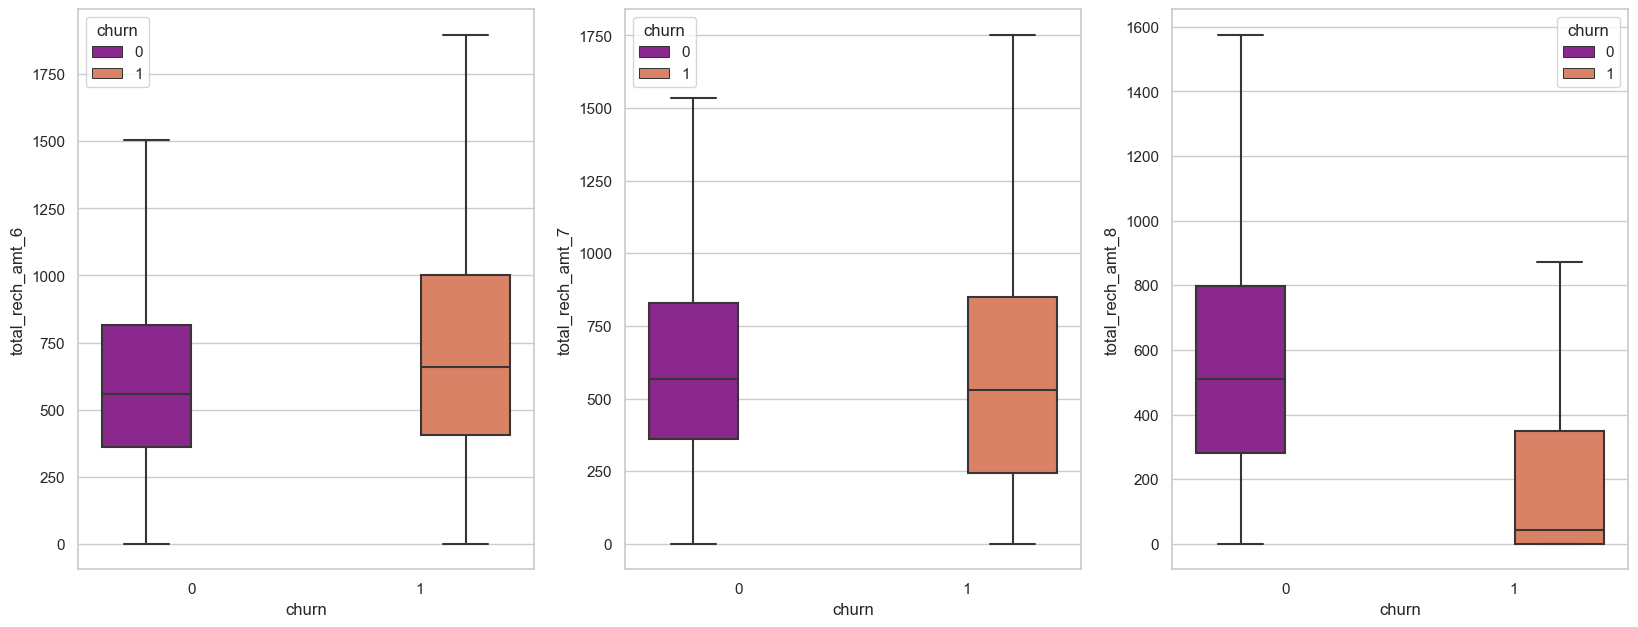

In [45]:
# plot box chart for total recharge amount
plot_box_chart("total_rech_amt")

There is a substantial decline in the total recharge count during the 8th month (action phase) for customers who eventually churned.

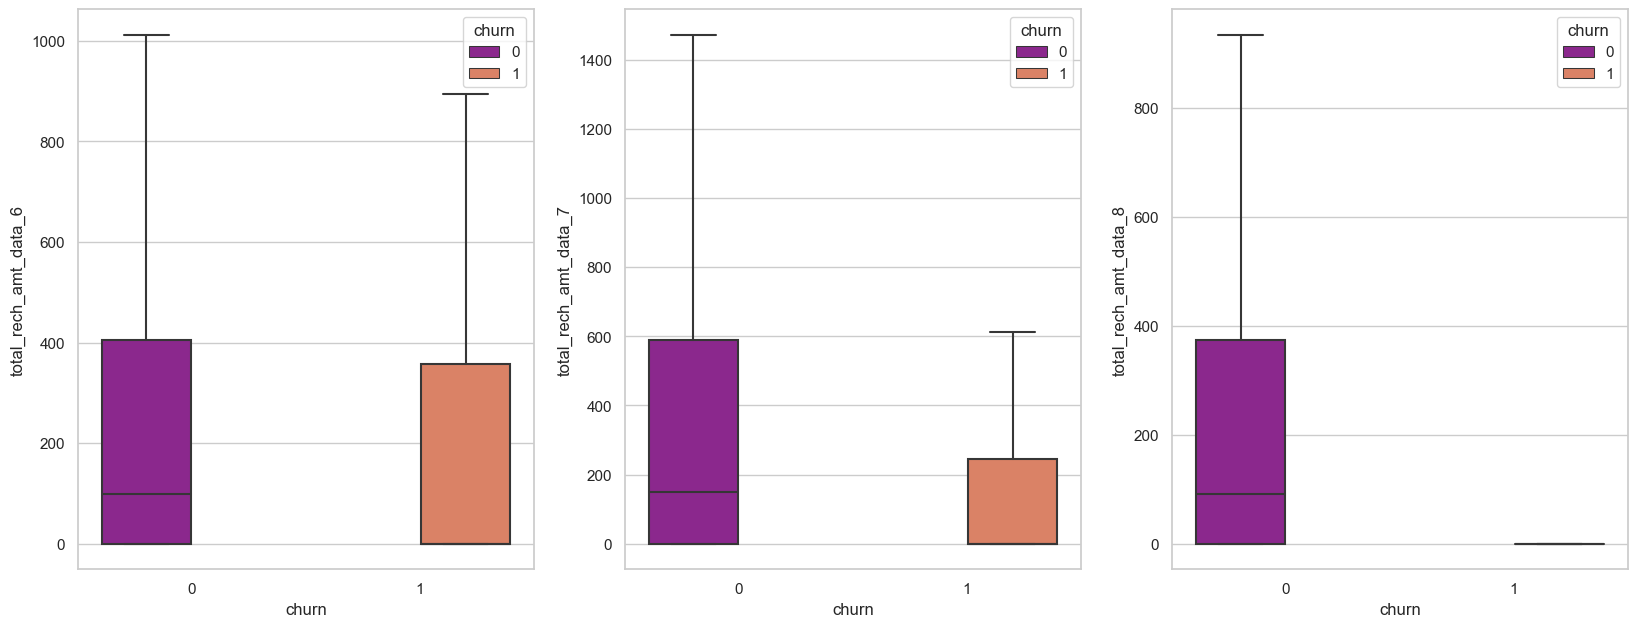

In [46]:
# plot box chart for total recharge amount for data
plot_box_chart("total_rech_amt_data")

There is also a substantial decline in total recharge amount for data during the 8th month (action phase) for customers who eventually churned.

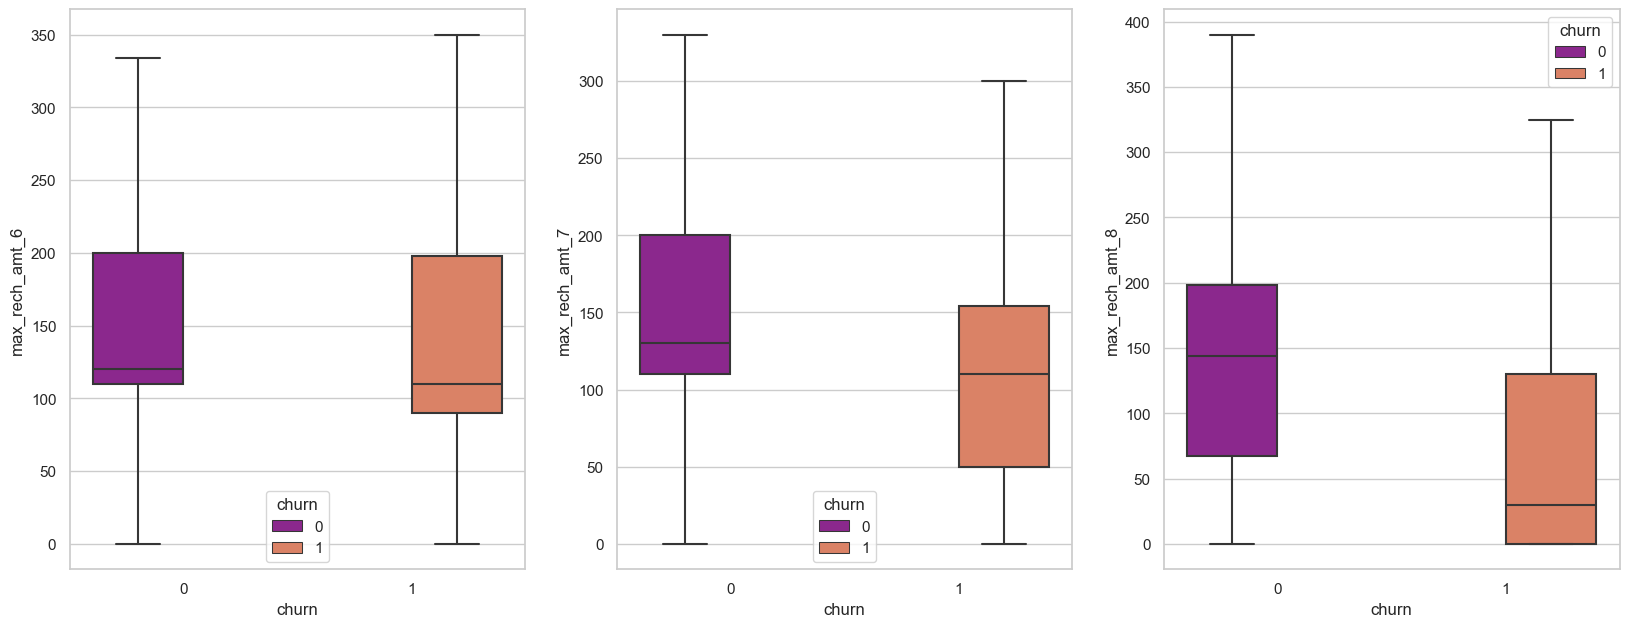

In [47]:
# plot box chart for maximum recharge amount for data
plot_box_chart("max_rech_amt")

There is also a substantial decline in the maximum recharge amount for data during the 8th month (action phase) for customers who eventually churned.

*Other recharge' related data*

In [48]:
# view other recharge' related data
other_recharges = high_val_custs.columns[high_val_custs.columns.str.contains('rech_num|max_rech_data',regex=True)]
other_recharges

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

In [49]:
# check null values percentages of other recharges
100*high_val_custs.loc[:,other_recharges].isnull().sum()/len(high_val_custs)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.11
max_rech_data_7                   43.12
max_rech_data_8                   46.80
dtype: float64

In [50]:
other_recharge_cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']

In [51]:
high_val_custs.loc[:,other_recharge_cols].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


Observing that the range of values spans from a minimum of 1 to a maximum of 1555 across months, implying that the missing values correspond to instances where no recharges occurred for data. Addressing this, filling the missing values with 0 signifies no recharge activity.

In [52]:
high_val_custs.loc[:,other_recharge_cols] = high_val_custs.loc[:,other_recharge_cols].replace(np.nan,0)

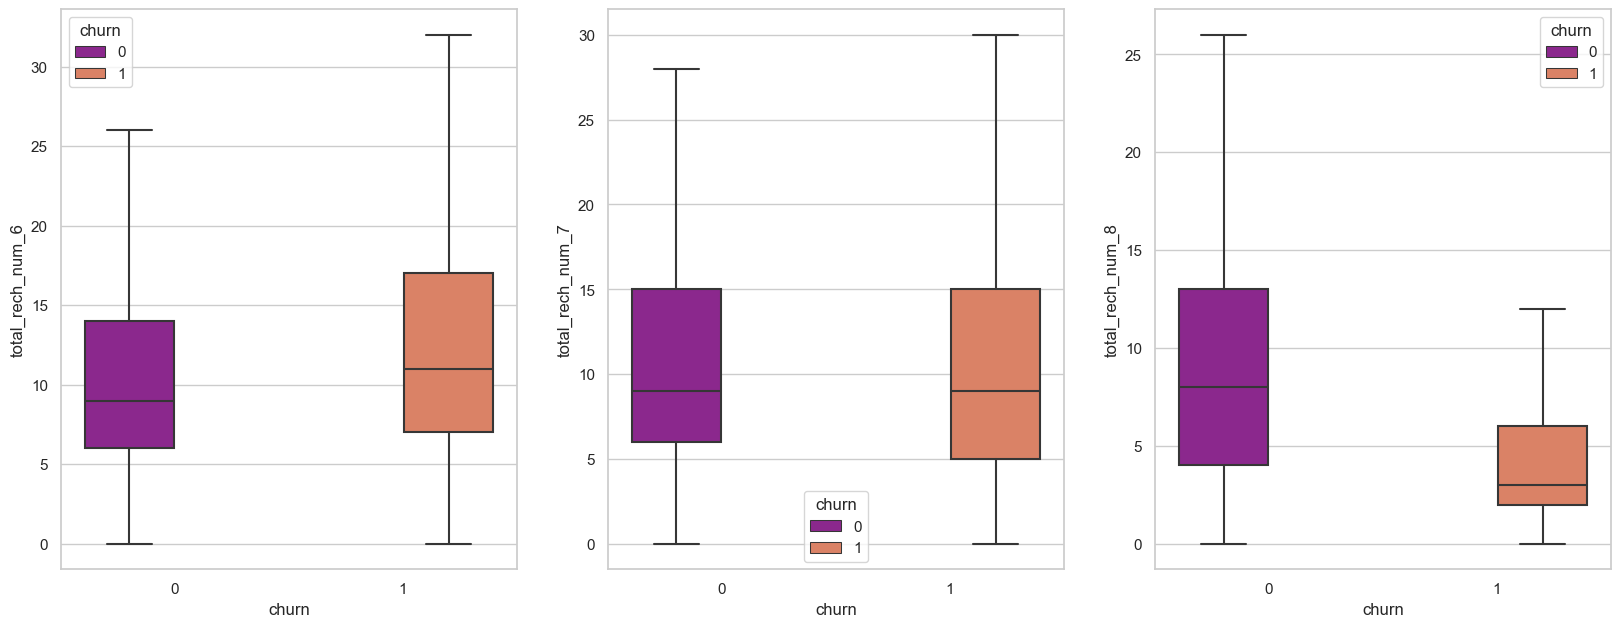

In [53]:
# plot box chart for total rechange number
plot_box_chart("total_rech_num")

There is also a substantial decline in the total rechange number during the 8th month (action phase) for customers who eventually churned.

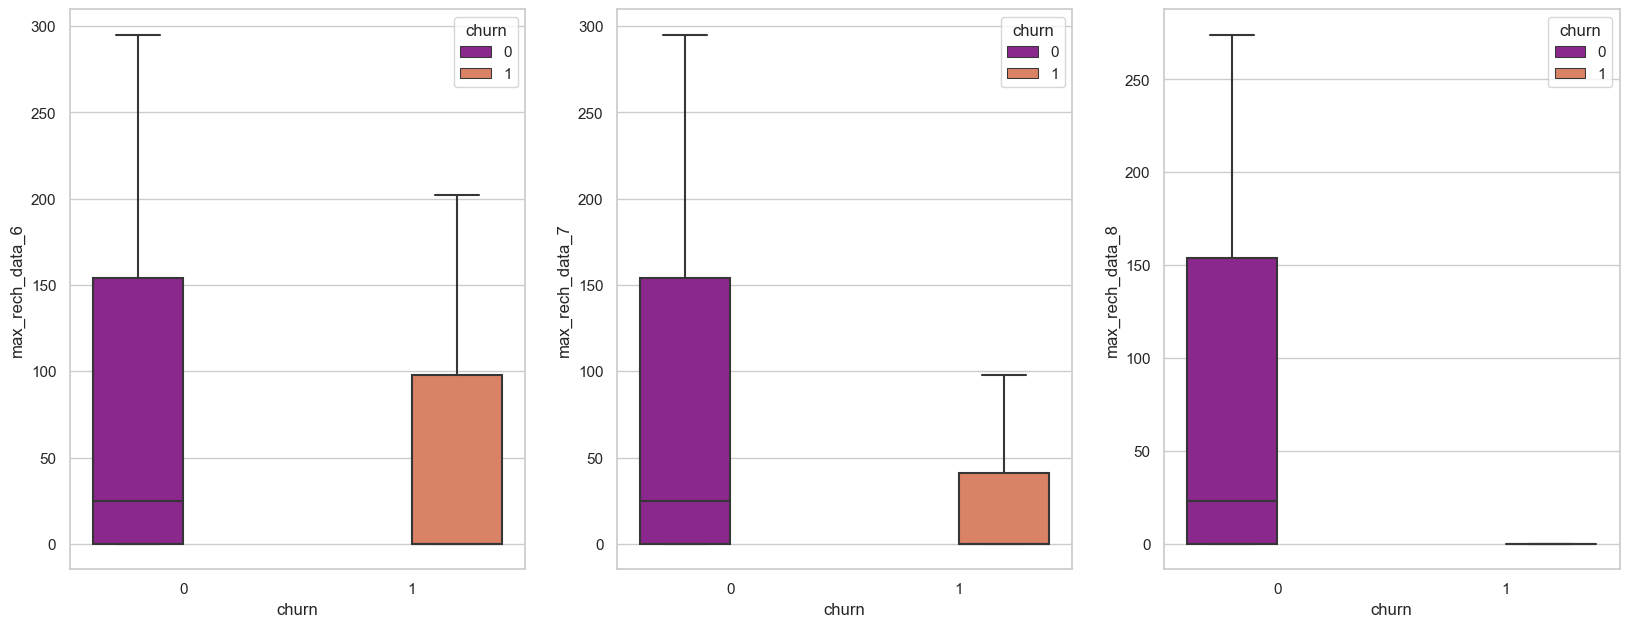

In [54]:
# plot box chart for maximun recharge data
plot_box_chart("max_rech_data")

There is also a substantial decline in the maximun recharge data during the 8th month (action phase) for customers who eventually churned.

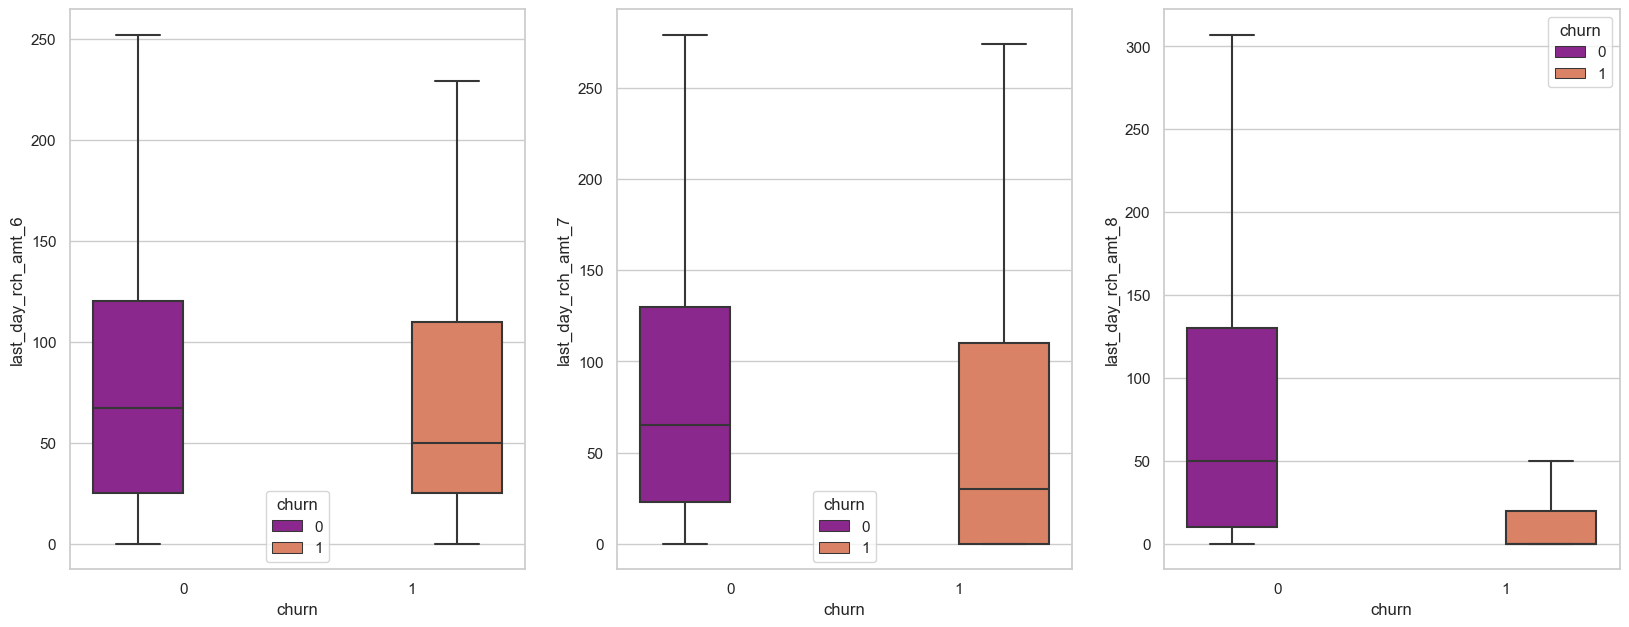

In [55]:
# plot box chart for last day recharge amount
plot_box_chart("last_day_rch_amt")

There is also a substantial decline in the last day recharge amount during the 8th month (action phase) for customers who eventually churned.

b) Attributes related to 2G and 3G usage

In [56]:
usage_2g_3gs = high_val_custs.columns[high_val_custs.columns.str.contains('2g|3g',regex=True)]
usage_2g_3gs

Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g'],
      dtype='object')

In [57]:
# check null values percentages of usage_2g_3gs
usage_2g_3g_null_percentage = 100*high_val_custs.loc[:,usage_2g_3gs].isnull().sum()/len(high_val_custs.loc[:,usage_2g_3gs])
usage_2g_3g_null_percentage

count_rech_2g_6                  44.11
count_rech_2g_7                  43.12
count_rech_2g_8                  46.80
count_rech_3g_6                  44.11
count_rech_3g_7                  43.12
count_rech_3g_8                  46.80
vol_2g_mb_6                       0.00
vol_2g_mb_7                       0.00
vol_2g_mb_8                       0.00
vol_3g_mb_6                       0.00
vol_3g_mb_7                       0.00
vol_3g_mb_8                       0.00
arpu_3g_6                        44.11
arpu_3g_7                        43.12
arpu_3g_8                        46.80
arpu_2g_6                        44.11
arpu_2g_7                        43.12
arpu_2g_8                        46.80
monthly_2g_6                      0.00
monthly_2g_7                      0.00
monthly_2g_8                      0.00
sachet_2g_6                       0.00
sachet_2g_7                       0.00
sachet_2g_8                       0.00
monthly_3g_6                      0.00
monthly_3g_7             

Observing that over 40% of values are missing for the count of recharge and average revenue for 2G/3G per user. Despite having 2G/3G volume usage data, considering the substantial missing values, it may be prudent to drop these columns.

In [58]:
# get the columns with only one unique value
usage_2g_3g_cols_to_drop = usage_2g_3g_null_percentage[usage_2g_3g_null_percentage > 40].index.to_list()
usage_2g_3g_cols_to_drop

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [59]:
# drop the columns
high_val_custs.drop(usage_2g_3g_cols_to_drop,axis=1,inplace=True)

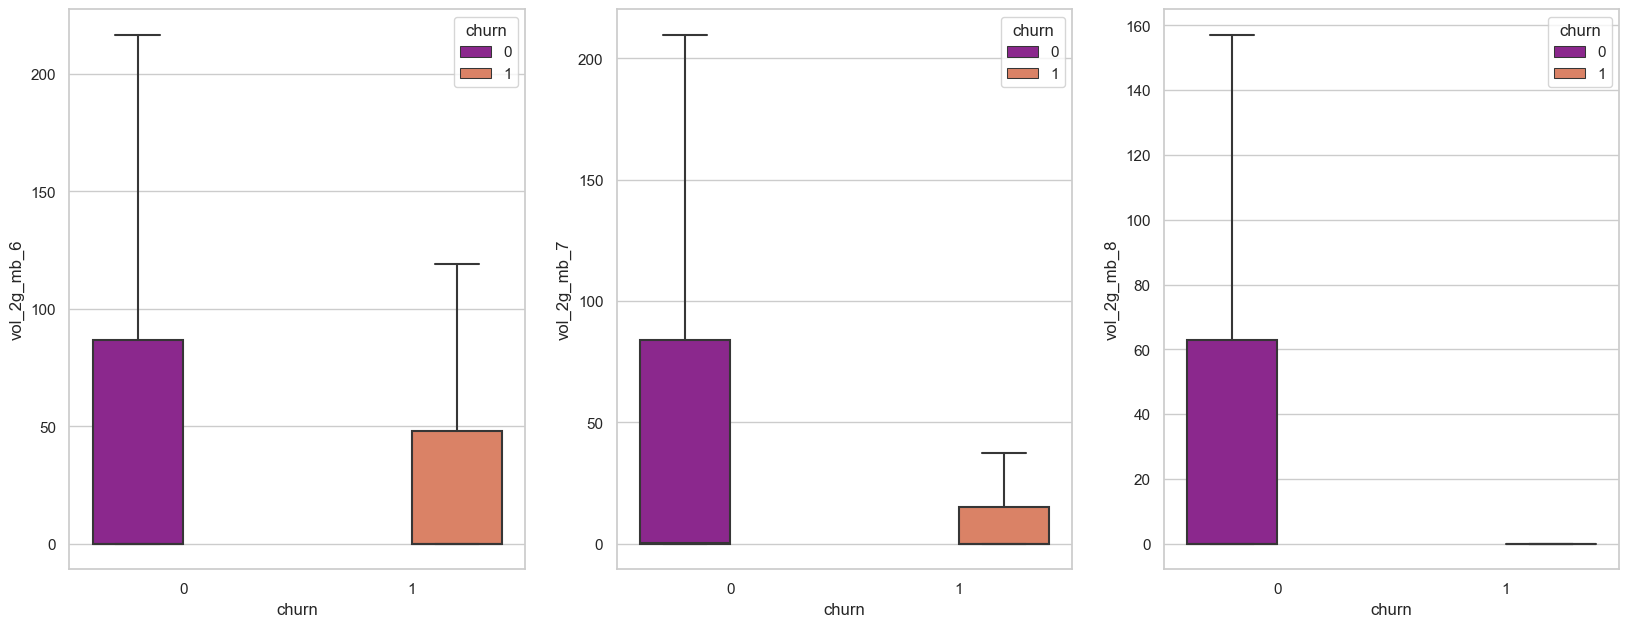

In [60]:
# plot box chart for volume of 2G usage columns
plot_box_chart("vol_2g_mb")

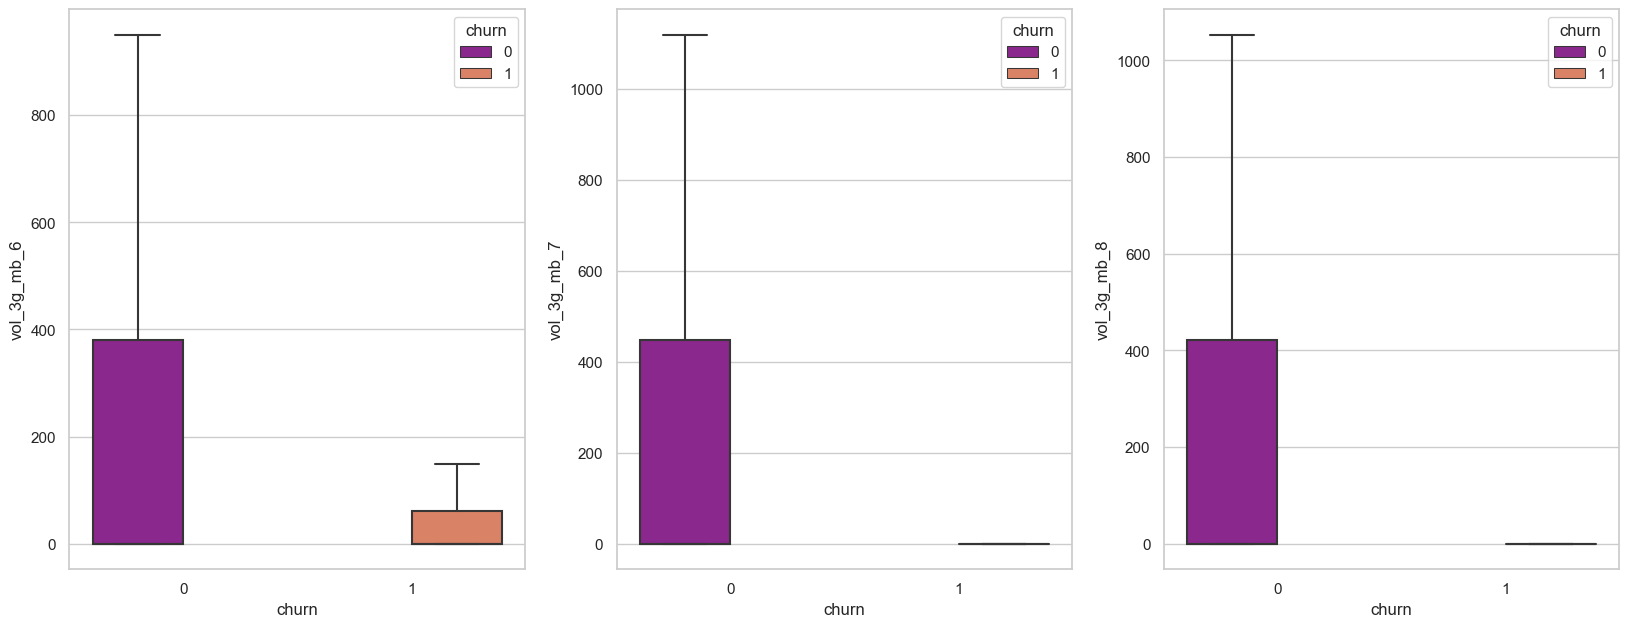

In [61]:
# plot box chart for volume of 3G usage columns
plot_box_chart("vol_3g_mb")

From the preceding observations, we can deduce two key insights:
1) The 2G and 3G usage for churned customers experiences a decline in the 8th month.
2) Additionally, the higher 2G/3G usage among non-churned customers suggests that areas with limited availability of 2G/3G services may be more prone to customer churn.

In [62]:
# check monthly 2G/3G service schemes
monthly_subcription_2g_3gs = high_val_custs.columns[high_val_custs.columns.str.contains('monthly_2g|monthly_3g',regex=True)].tolist()
monthly_subcription_2g_3gs

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [63]:
# check null values percentages of monthly_subcription_2g_3gs
100*high_val_custs.loc[:,monthly_subcription_2g_3gs].isnull().sum()/len(high_val_custs.loc[:,monthly_subcription_2g_3gs])

monthly_2g_6                   0.00
monthly_2g_7                   0.00
monthly_2g_8                   0.00
monthly_3g_6                   0.00
monthly_3g_7                   0.00
monthly_3g_8                   0.00
dtype: float64

In [64]:
high_val_custs[monthly_subcription_2g_3gs].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


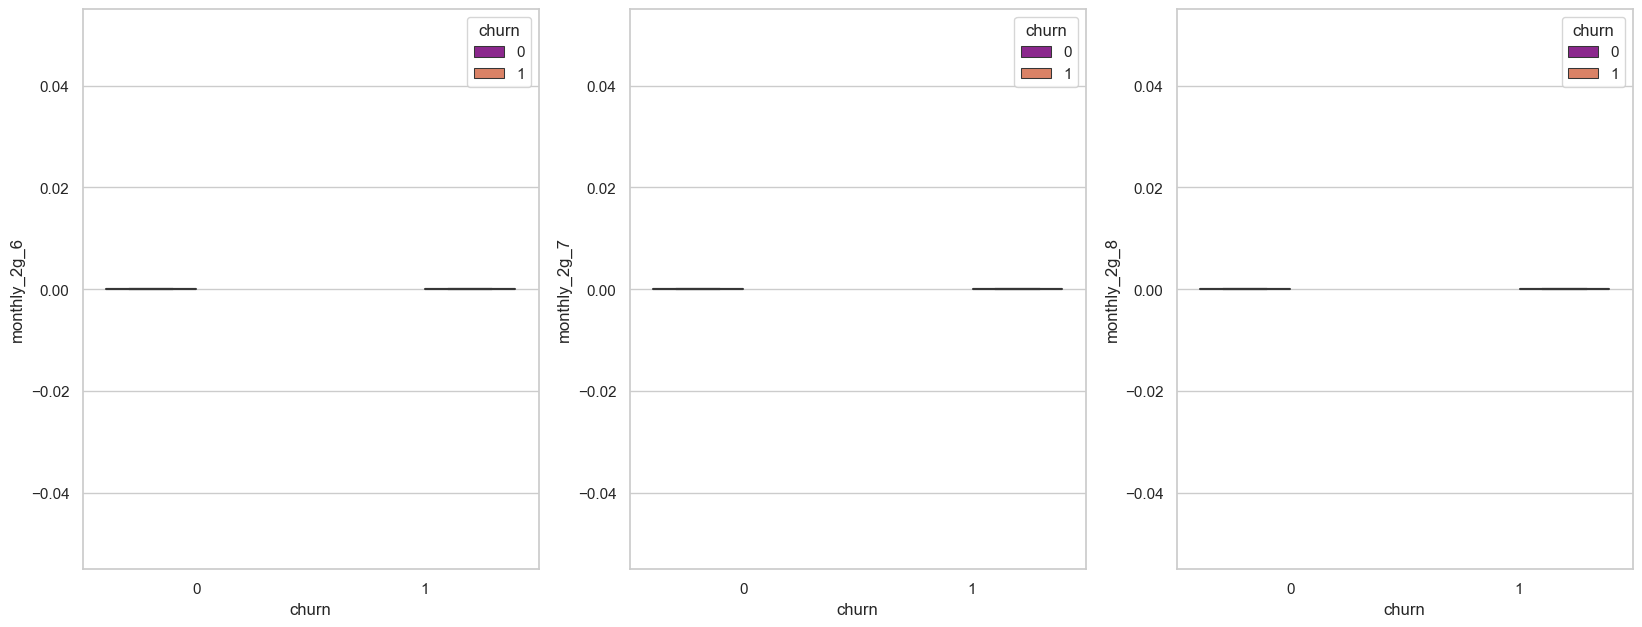

In [65]:
# plot box chart for 2g monthly subscription
plot_box_chart("monthly_2g")

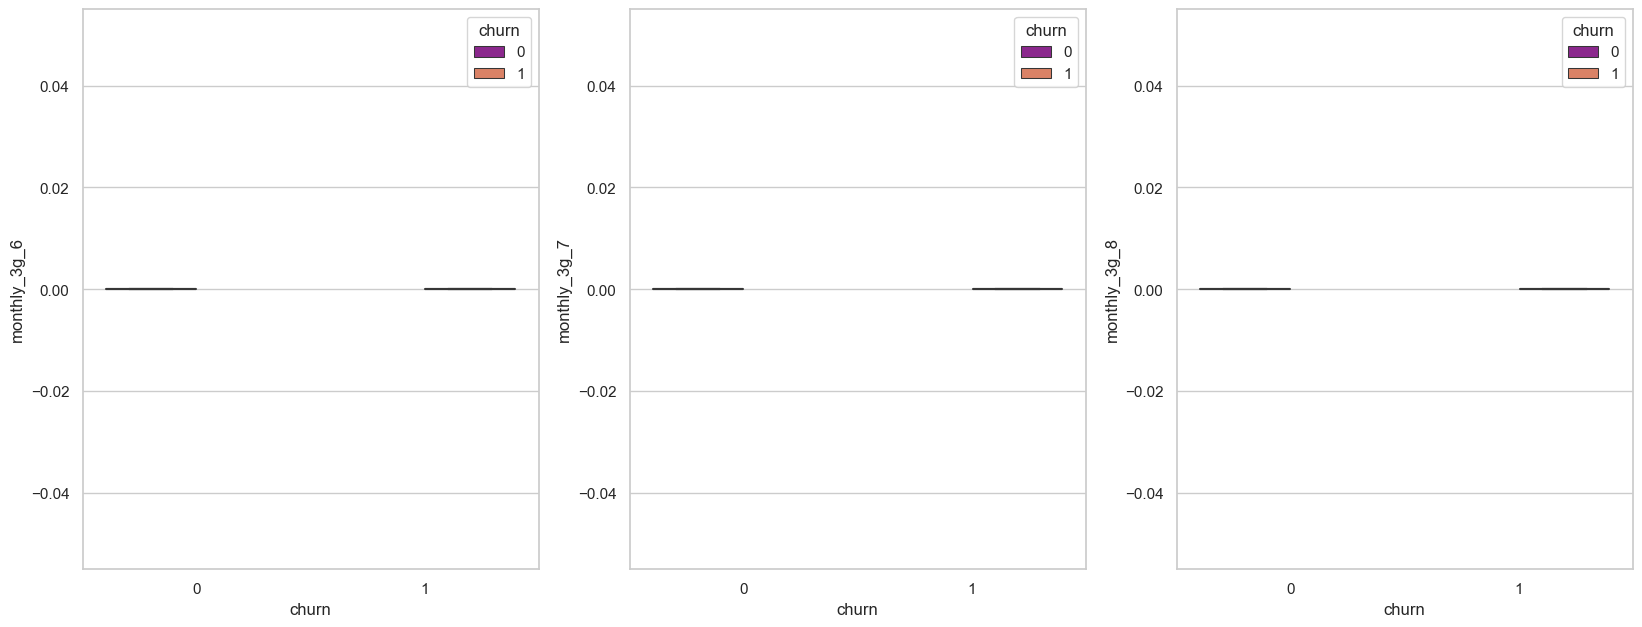

In [66]:
# plot box chart for 3g monthly subscription
plot_box_chart("monthly_3g")

*Due to the narrow range of values, the graph does not provide a clear justification. Therefore, conducting an analysis by examining the mean value for a more comprehensive understanding.*

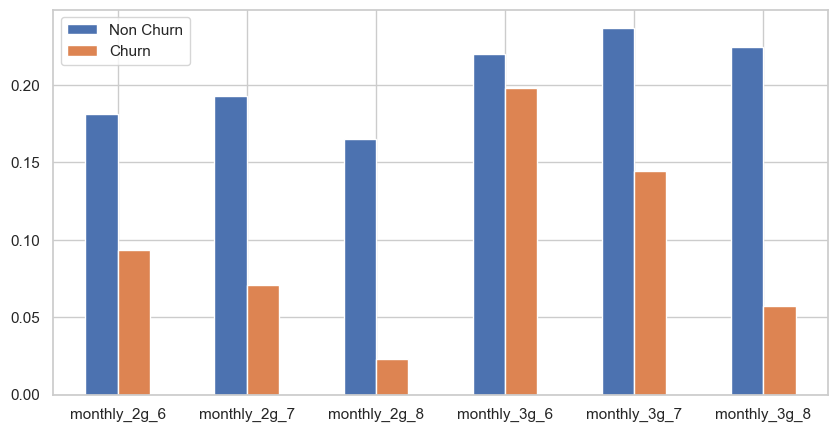

In [67]:
plot_mean_bar_chart(high_val_custs, monthly_subcription_2g_3gs)

Once more, there is evident reduction in monthly subscription for customers who churned, particularly in the 8th month.

In [68]:
# check volume based cost
vbc_cols = high_val_custs.columns[high_val_custs.columns.str.contains('vbc_',regex=True)].to_list()
vbc_cols

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [69]:
# renaming the columns in the "vbc" category to follow the format of months 6, 7, 8, and 9
high_val_custs.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)

In [70]:
# drop 9th month column which is not needed
high_val_custs.drop('vbc_3g_9',axis=1,inplace=True)

In [71]:
vbc_cols = high_val_custs.columns[high_val_custs.columns.str.contains('vbc_',regex=True)].to_list()
vbc_cols

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

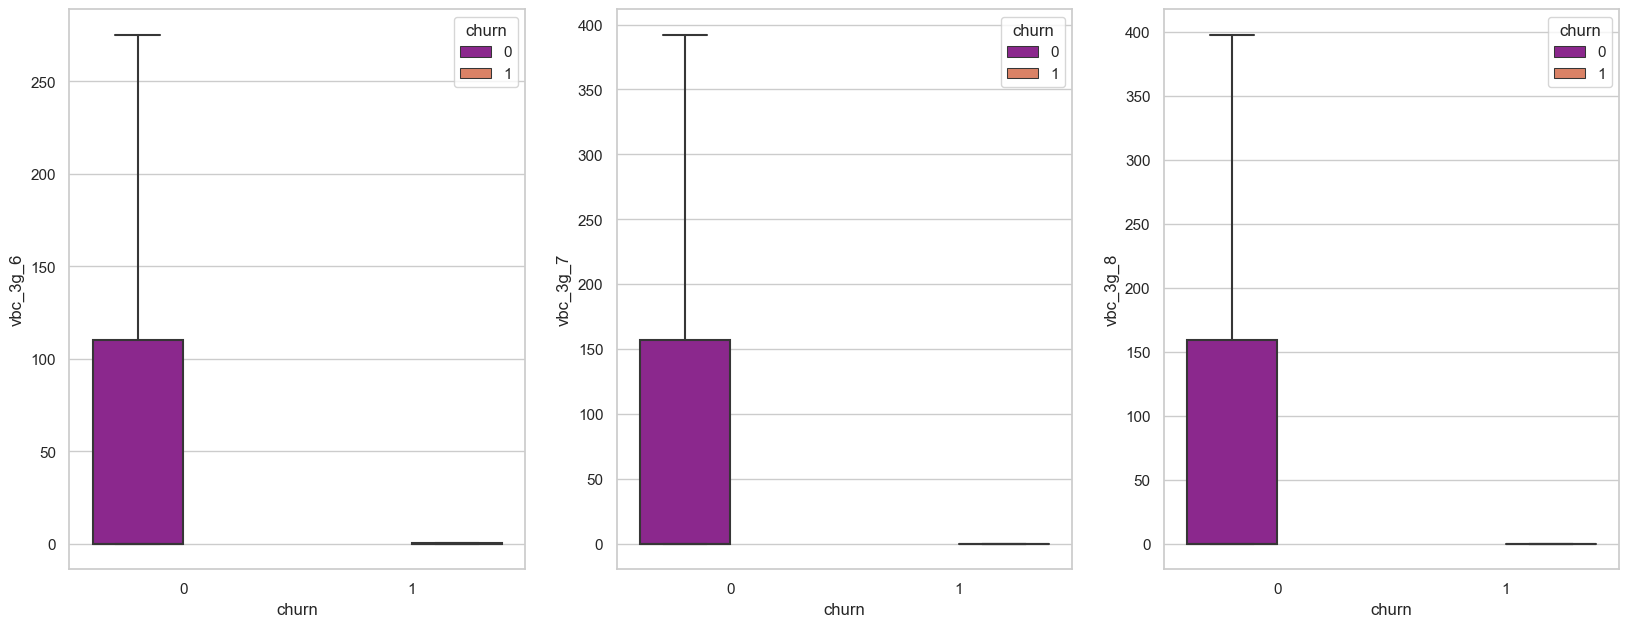

In [72]:
# plot box chart for volume based cost
plot_box_chart("vbc_3g")

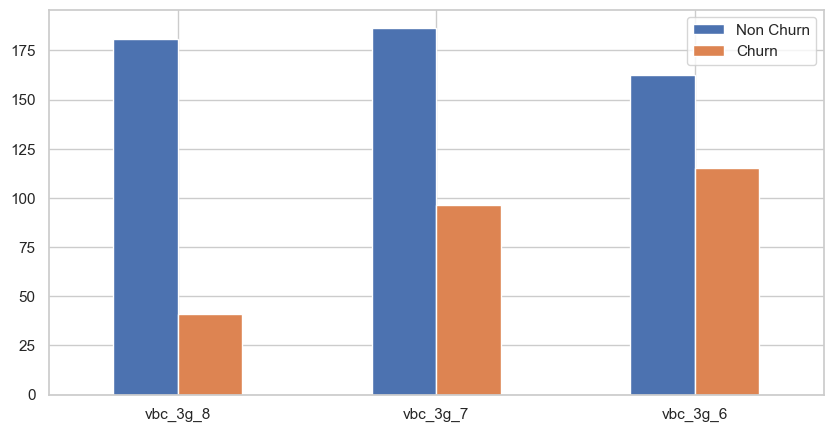

In [73]:
plot_mean_bar_chart(high_val_custs, vbc_cols)

The analysis reveals a notable difference in the volume-based cost for 3G, indicating a lower cost for churned customers compared to non-churned customers. Additionally, there is a discernible decrease in volume-based cost during the 8th month.

In [74]:
# checking service schemes with a validity period shorter than a month for both 2G and 3G
sc_2g_or_3g_cols = high_val_custs.columns[high_val_custs.columns.str.contains('sachet_2g|sachet_3g',regex=True)].to_list()
sc_2g_or_3g_cols

['sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

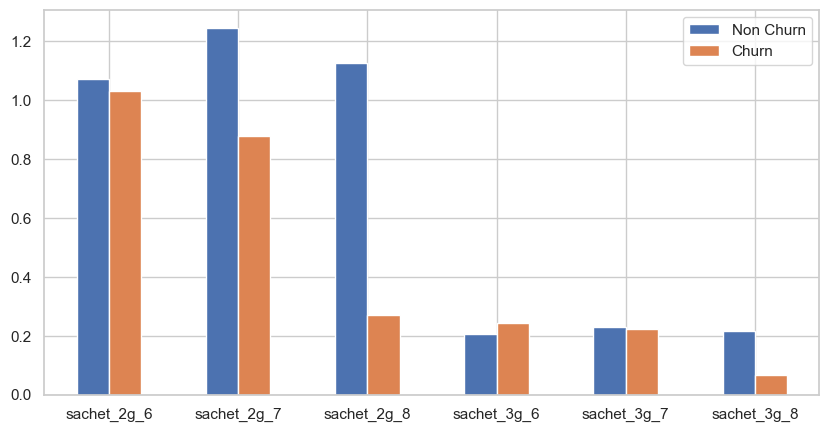

In [75]:
plot_mean_bar_chart(high_val_custs, sc_2g_or_3g_cols)

There is an observable decline in sachet services during the 8th month for customers who eventually churned.

c) Average Revenue Per User

In [76]:
# checking columns related to the average revenue per user
arpu_cols = high_val_custs.columns[high_val_custs.columns.str.contains('arpu_')].to_list()
arpu_cols

['arpu_6', 'arpu_7', 'arpu_8']

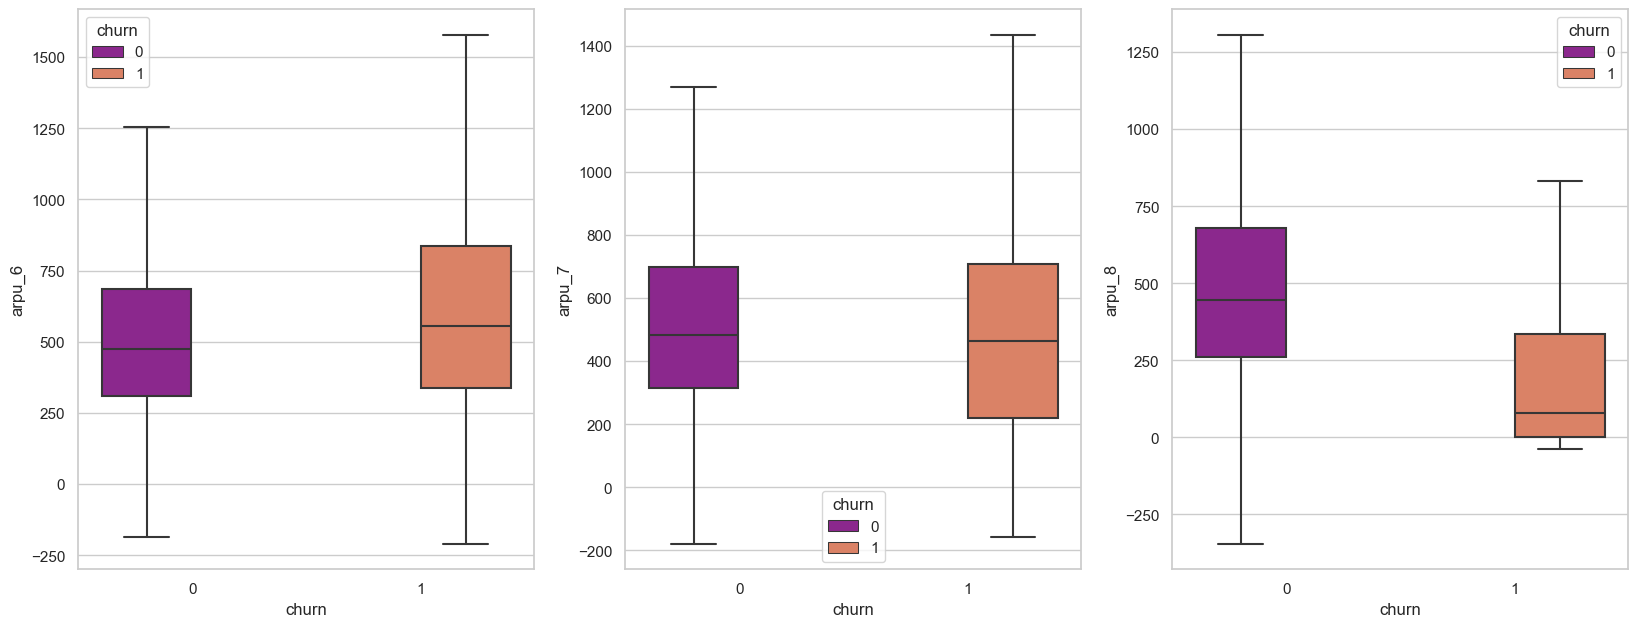

In [77]:
# plot box chart for average revenue per user
plot_box_chart("arpu")

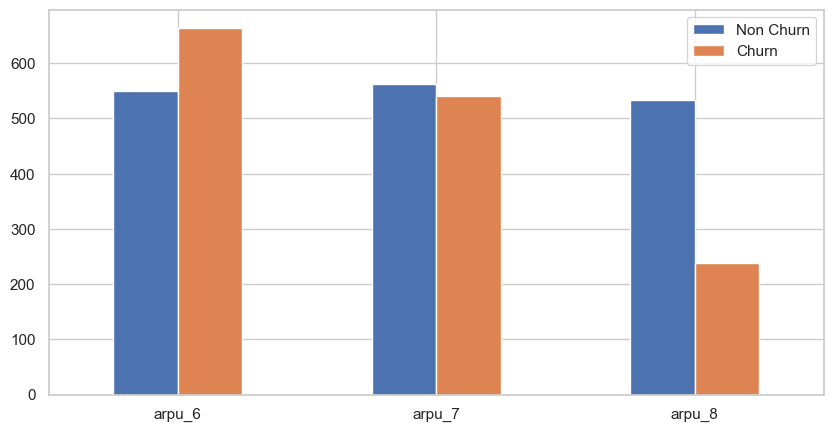

In [78]:
plot_mean_bar_chart(high_val_custs, arpu_cols)

Significant decreases in Average Revenue Per User (ARPU) are evident during the 8th month for customers who eventually churned.

d) Minutes of usage - voice calls

In [79]:
# checking columns related to minutes of usage - voice calls
mou_cols = high_val_custs.columns[high_val_custs.columns.str.contains('mou')].to_list()
mou_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_i

In [80]:
mou_metadata = create_metadata_df(high_val_custs[mou_cols])
mou_metadata.sort_values(["Missing_Percentages"], axis=0,ascending=False, inplace=True)
mou_metadata

,Data_Type,Unique_Values,Non_Null_Values,Missing_Values,Missing_Percentages,Variable_Type,frequency
isd_ic_mou_8,float64,3357,28781,1172,3.91,Continuous,0
loc_ic_t2t_mou_8,float64,9359,28781,1172,3.91,Continuous,0
loc_ic_t2m_mou_8,float64,15110,28781,1172,3.91,Continuous,0
std_og_t2t_mou_8,float64,10243,28781,1172,3.91,Continuous,0
loc_og_t2c_mou_8,float64,1720,28781,1172,3.91,Continuous,0
...,...,...,...,...,...,...,...
total_ic_mou_6,float64,20099,29953,0,0.00,Continuous,0
total_ic_mou_7,float64,20143,29953,0,0.00,Continuous,0
total_ic_mou_8,float64,19565,29953,0,0.00,Continuous,0
total_og_mou_6,float64,23492,29953,0,0.00,Continuous,0


The maximum missing percentage for all minutes of usage columns is 3.91%, suggesting that in these instances, customers have not used any minutes for the respective call types. Consequently, filling the missing values with zero is a reasonable approach.

In [81]:
# replacing null values with zero for the minutes of usage variables
high_val_custs.loc[:,mou_cols] = high_val_custs.loc[:,mou_cols].replace(np.NaN,0)

In [82]:
mou_og_6_cols = high_val_custs.columns[high_val_custs.columns.str.contains('.*_og_.*mou_6',regex=True)].to_list()
mou_og_6_cols

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6']

In [83]:
high_val_custs.loc[:,mou_og_6_cols].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


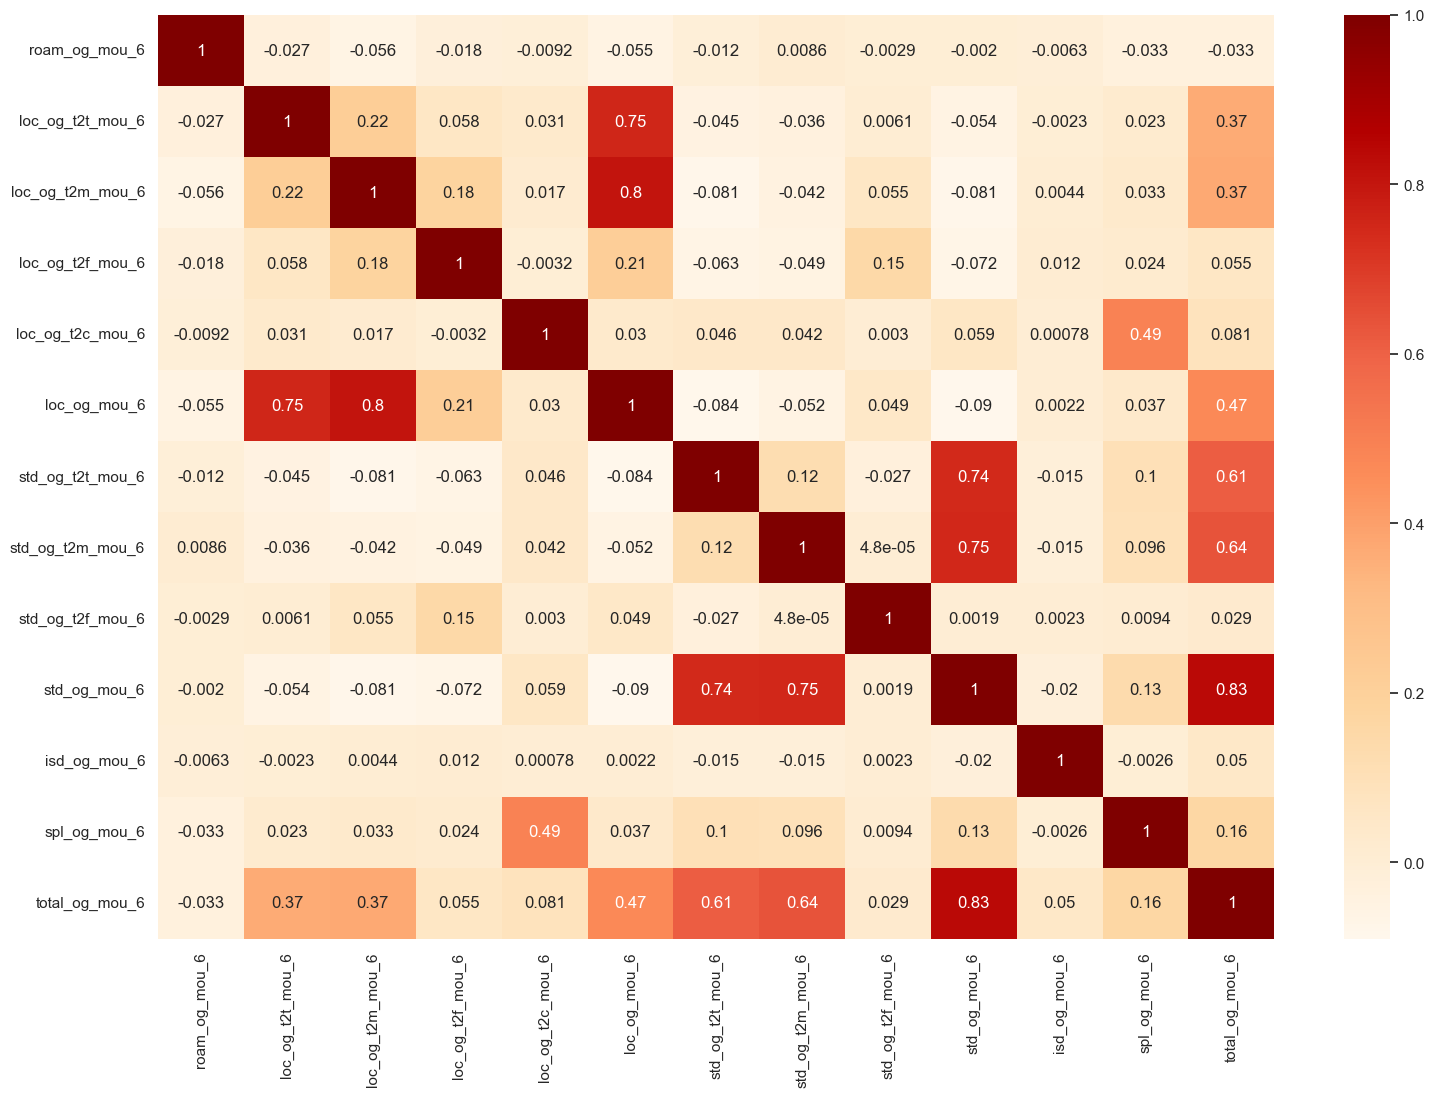

In [84]:
heatmap(18,12,high_val_custs.filter(mou_og_6_cols))

Observing that total_og_mou_6, std_og_mou_6, and loc_og_mou_6 exhibit strong correlations with other fields, indicating the necessity for inspection to mitigate potential multicollinearity issues.

In [85]:
print("total_og_mou_6 : ", high_val_custs.loc[8,'total_og_mou_6'],"==",high_val_custs.loc[8,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())
print("std_og_mou_6   : ", high_val_custs.loc[8,'std_og_mou_6'],"==",high_val_custs.loc[8,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6']].sum())
print("loc_og_mou_6   : " , high_val_custs.loc[8,'loc_og_mou_6'],"==",high_val_custs.loc[8,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6']].sum())

total_og_mou_6 :  508.36 == 508.34999999999997
std_og_mou_6   :  130.26 == 130.25
loc_og_mou_6   :  378.09 == 378.09


Observing that total_og_mou_6, std_og_mou_6, and loc_og_mou_6 are combinations of other variables in the dataset. Consequently, it is feasible to eliminate these columns for all months from the dataset.

In [86]:
list_total_og_cols = high_val_custs.columns[high_val_custs.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)].to_list()
list_total_og_cols

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

In [87]:
# drop columns
high_val_custs.drop(list_total_og_cols,axis=1,inplace=True)

In [88]:
# checking variables related to incoming minutes of usage
mou_ic_6_cols = high_val_custs.columns[high_val_custs.columns.str.contains('.*_ic_.*mou_6',regex=True)].to_list()
mou_ic_6_cols

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

In [89]:
high_val_custs.loc[:,mou_ic_6_cols].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


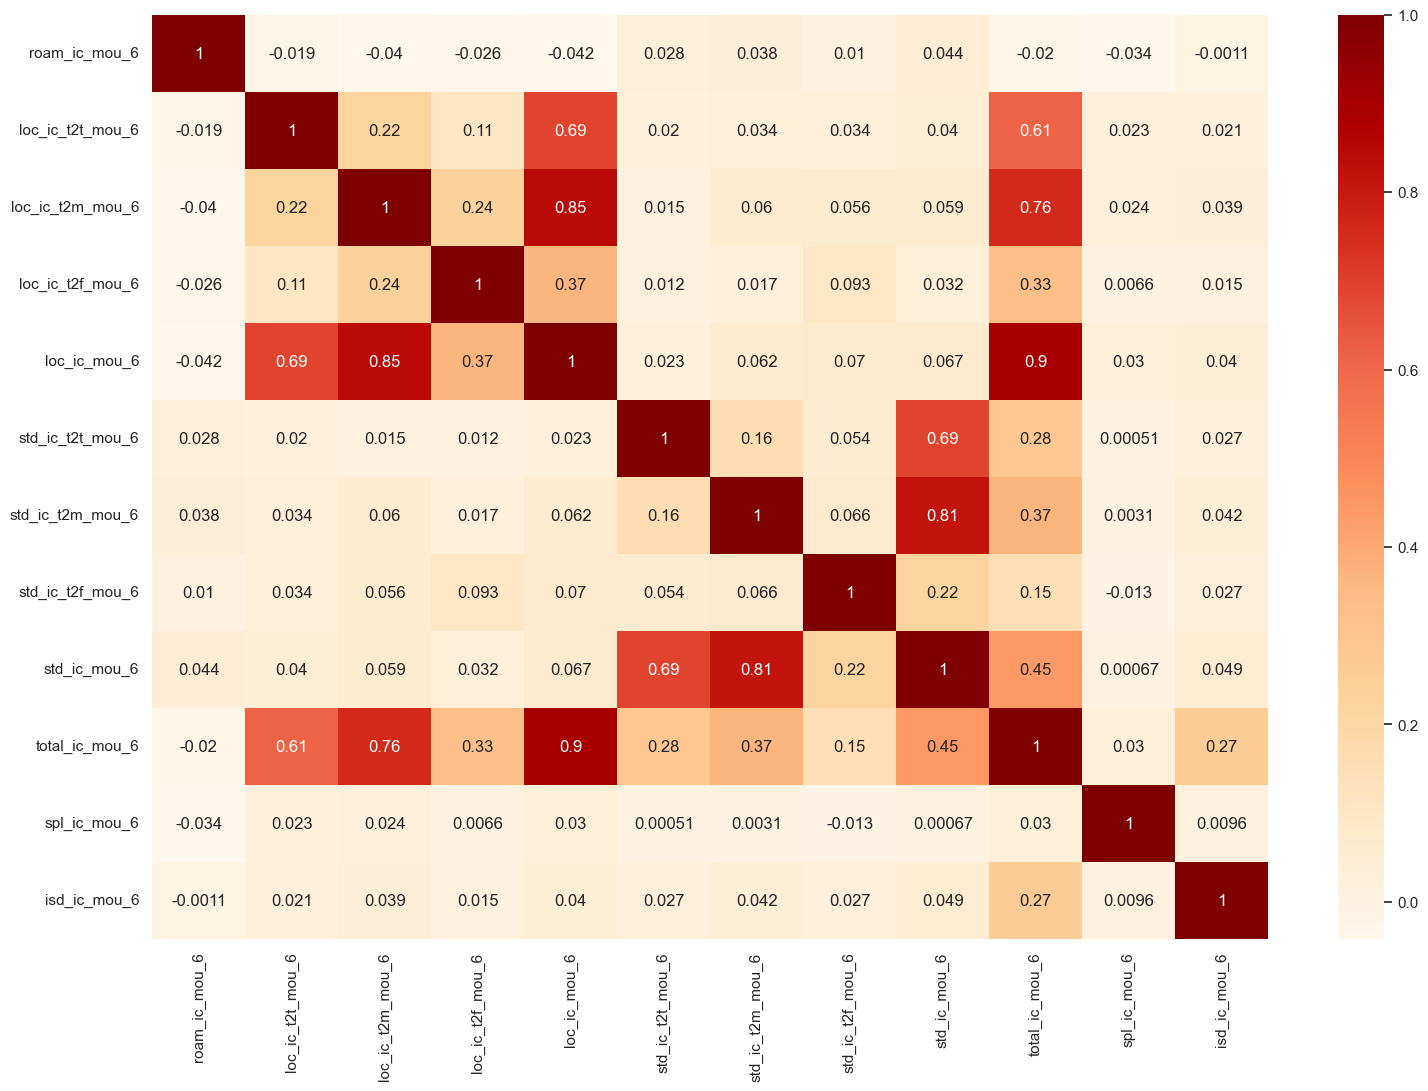

In [90]:
heatmap(18,12,high_val_custs.filter(mou_ic_6_cols))

Observing that total_ic_mou_6, std_ic_mou_6, and loc_ic_mou_6 exhibit strong correlations with other fields, indicating the necessity for inspection to mitigate potential multicollinearity issues

In [91]:
print("total_ic_mou_6 : ", high_val_custs.loc[21,'total_ic_mou_6'],"==",high_val_custs.loc[21,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
print("loc_ic_mou_6   : ", high_val_custs.loc[21,'loc_ic_mou_6'],"==",high_val_custs.loc[21,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())
print("std_ic_mou_6   : ", high_val_custs.loc[21,'std_ic_mou_6'],"==",high_val_custs.loc[21,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())

total_ic_mou_6 :  207.09 == 207.09
loc_ic_mou_6   :  125.33 == 125.32000000000001
std_ic_mou_6   :  81.76 == 81.75


Observing that total_ic_mou_6, std_ic_mou_6, and loc_ic_mou_6 are combinations of other variables in the dataset. Consequently, it is feasible to eliminate these columns for all months from the dataset.

In [92]:
total_std_loc_ic_cols = high_val_custs.columns[high_val_custs.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)].to_list()
total_std_loc_ic_cols

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [93]:
high_val_custs.drop(total_std_loc_ic_cols,axis=1,inplace=True)

e) Offnet Usage

In [94]:
offnet_usage_service_cols = high_val_custs.columns[high_val_custs.columns.str.contains('offnet.*mou',regex=True)].to_list()
offnet_usage_service_cols

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']

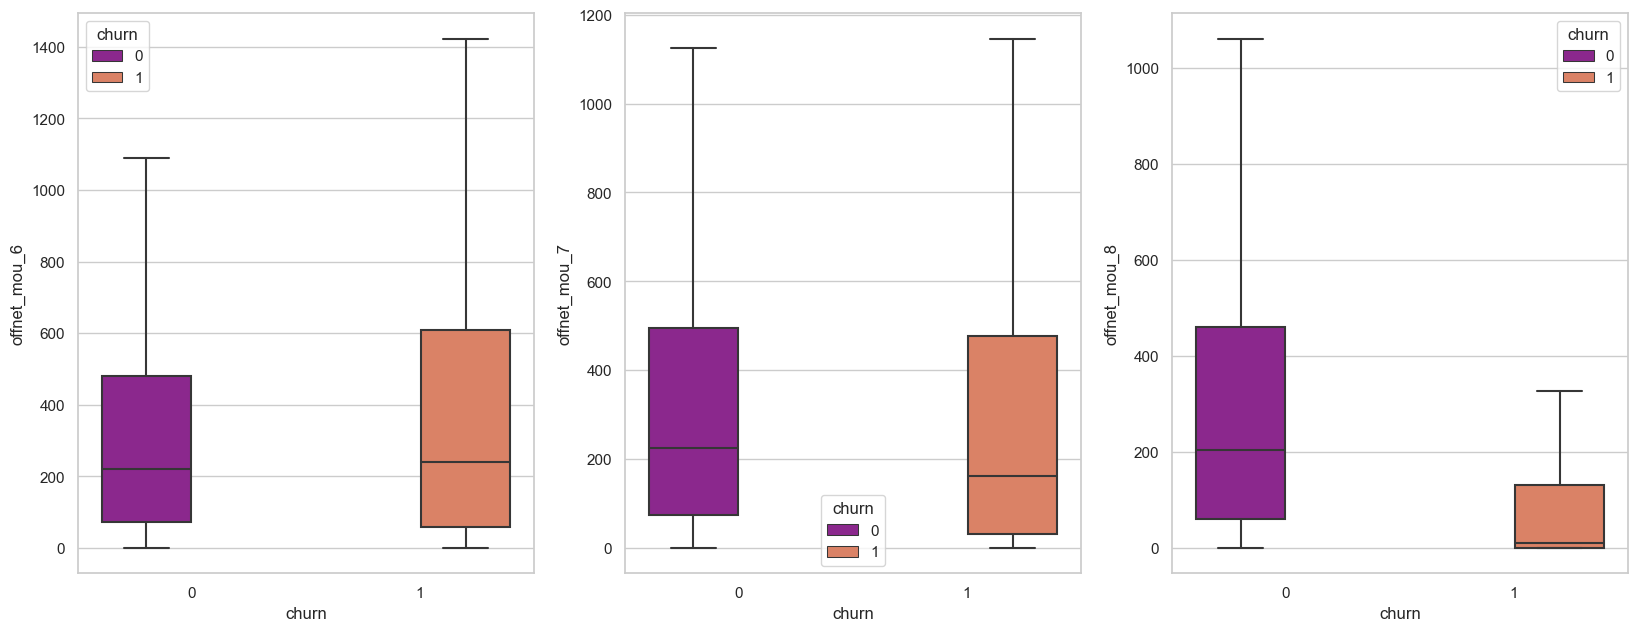

In [95]:
# plot box chart for Offnet mou values for churned and non churned customers
plot_box_chart("offnet_mou")

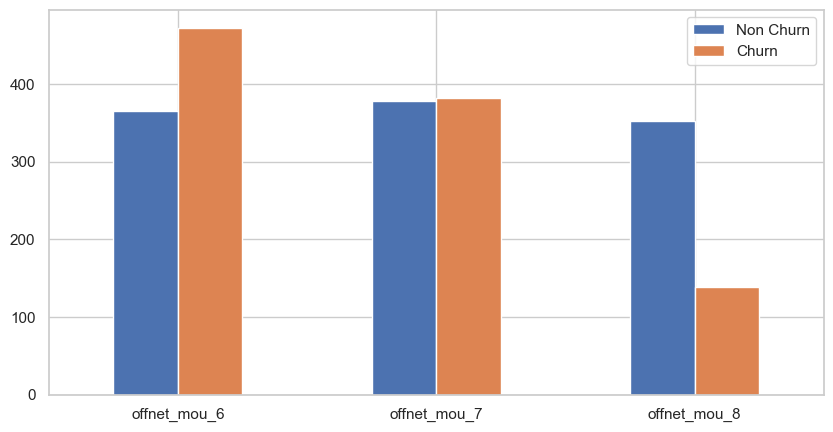

In [96]:
plot_mean_bar_chart(high_val_custs, offnet_usage_service_cols)

There is a noticeable decrease in off-net minutes of usage services during the 8th month.

f) ONNET : All kind of calls within the same operator network

In [97]:
# columns related to minutes of usage
onnet_usage_service_cols =  high_val_custs.columns[high_val_custs.columns.str.contains('^onnet.*mou',regex=True)].to_list()
onnet_usage_service_cols

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']

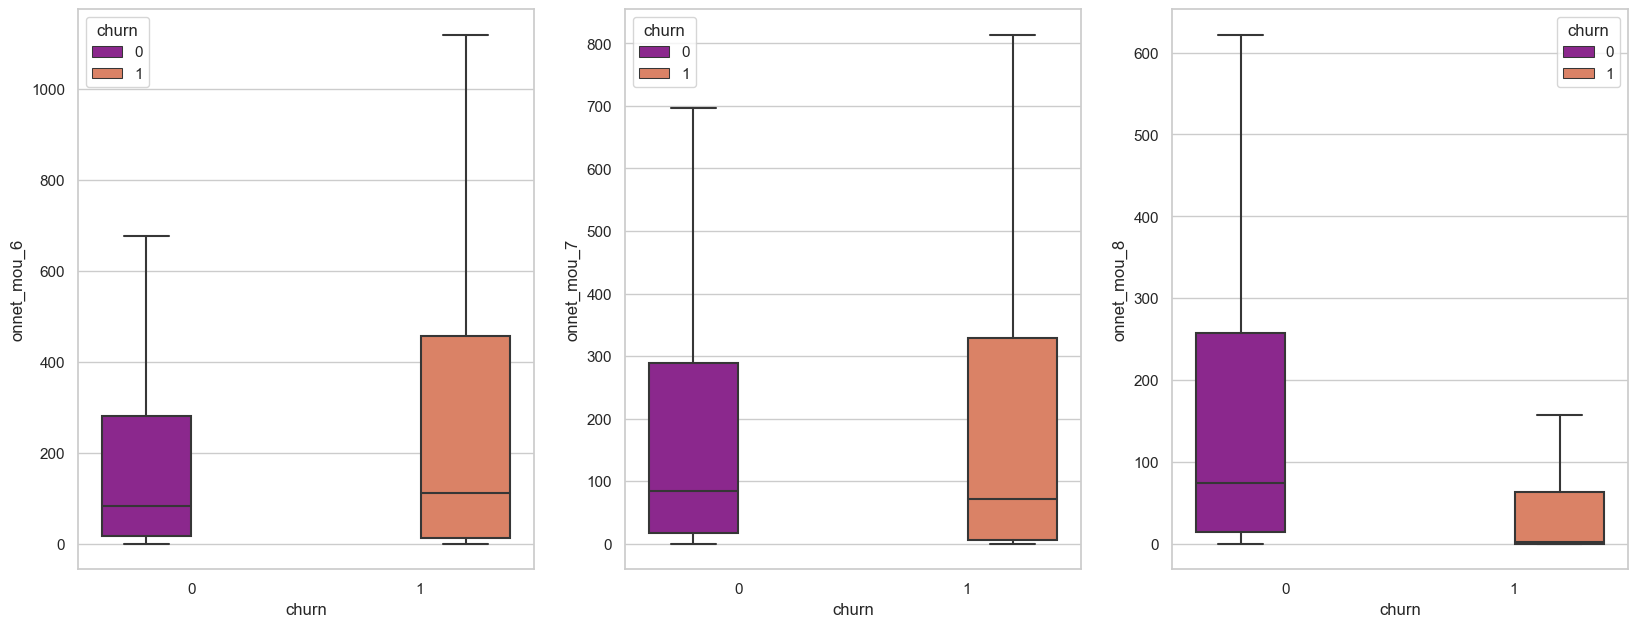

In [98]:
# plot box chart for minutes of usage
plot_box_chart("onnet_mou")

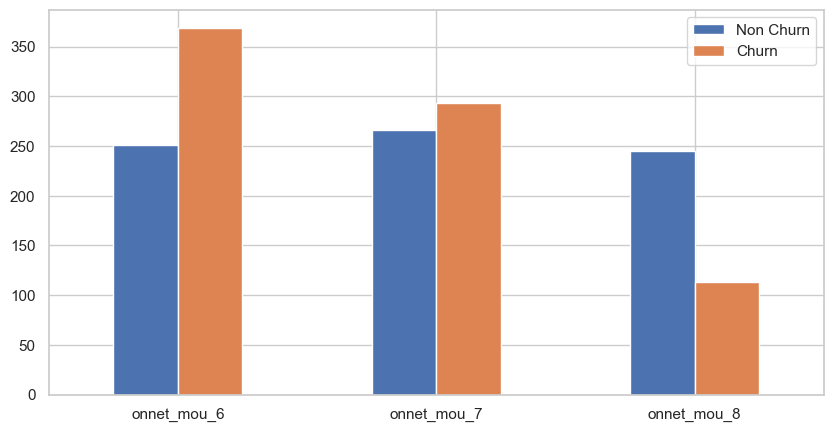

In [99]:
plot_mean_bar_chart(high_val_custs, onnet_usage_service_cols)

Additionally, there is a decline in on-net usage during the 8th month for customers who eventually churned.

g) Analyzing the tenure of customers

In [100]:
tenures = high_val_custs.copy()

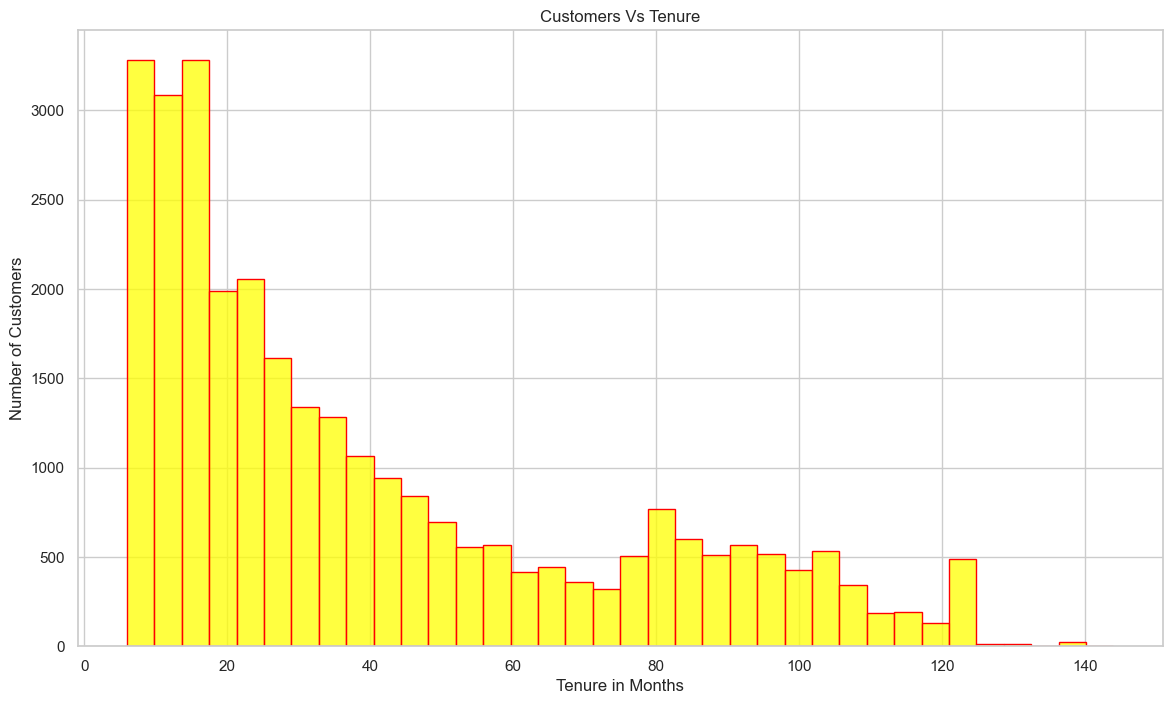

In [101]:
plt.figure(figsize=(14, 8))
tenures['tenure'] = tenures['aon'] / 30

ax = sns.histplot(tenures['tenure'], bins=int(180/5), color='yellow', edgecolor='red')
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')

plt.show()

In [102]:
tenures['tenure_range'] = pd.cut(tenures['tenure'], bins=[0, 6, 12, 24, 60, 61], labels=['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above'])
tenures['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

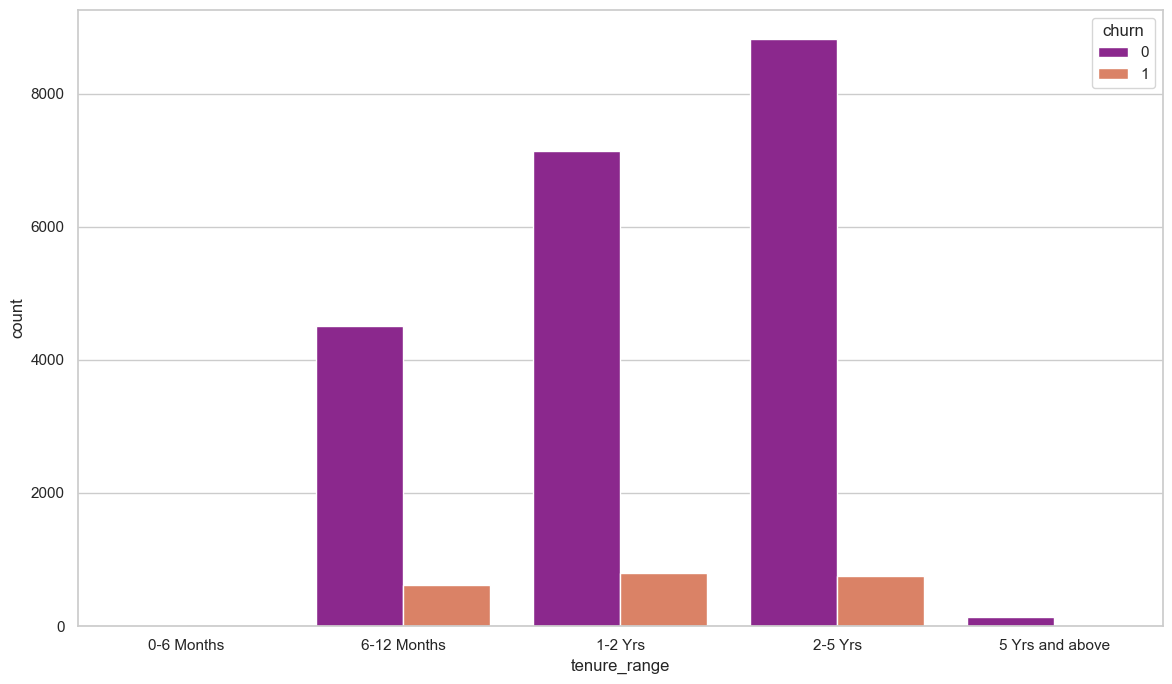

In [103]:
plt.figure(figsize=(14, 8))
sns.countplot(x='tenure_range', hue='churn', data=tenures, palette='plasma')
plt.show()

In [104]:
# checking columns that contain more than 30% missing values
metadata = create_metadata_df(high_val_custs)
metadata = metadata[metadata["Missing_Percentages"] > 30]
metadata.sort_values(["Missing_Percentages"], axis=0,ascending=False, inplace=True)
metadata['Missing_Percentages']

date_of_last_rech_data_8                  46.80
night_pck_user_8                          46.80
fb_user_8                                 46.80
date_of_last_rech_data_6                  44.11
night_pck_user_6                          44.11
fb_user_6                                 44.11
date_of_last_rech_data_7                  43.12
night_pck_user_7                          43.12
fb_user_7                                 43.12
Name: Missing_Percentages, dtype: float64

In [105]:
#drop over 30% columns
high_val_custs.drop(high_val_custs[metadata.index],axis=1,inplace=True)

In [106]:
high_val_custs.shape

(29953, 124)

**Replace Missing Values**

In [107]:
# checking columns that contain more than 0% missing values
metadata = create_metadata_df(high_val_custs)
metadata = metadata[metadata["Missing_Percentages"] > 0]
metadata.sort_values(["Missing_Percentages"], axis=0,ascending=False, inplace=True)
metadata['Missing_Percentages']

og_others_8                           3.91
ic_others_8                           3.91
date_of_last_rech_8                   1.94
og_others_6                           1.81
ic_others_6                           1.81
og_others_7                           1.79
ic_others_7                           1.79
date_of_last_rech_7                   0.33
date_of_last_rech_6                   0.24
Name: Missing_Percentages, dtype: float64

In [108]:
high_val_custs[metadata.index]

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,NaN,NaN,NaN,NaN,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18
...,...,...,...,...,...,...,...,...,...
99981,0.00,0.51,2014-08-27,0.00,0.15,0.00,0.00,2014-07-25,2014-06-17
99984,0.00,0.00,2014-08-27,1.06,0.00,0.00,0.00,2014-07-31,2014-06-21
99986,0.00,0.00,2014-08-18,0.00,0.00,0.00,0.00,2014-07-28,2014-06-20
99988,0.00,0.31,2014-08-29,0.00,0.20,0.00,0.00,2014-07-28,2014-06-30


Replacing missing values with zero for all numeric data, considering that the majority of the data is already clean and this replacement is unlikely to impact the analysis.

In [109]:
numeric_cols = ['og_others_8', 'ic_others_8', 'og_others_6', 'ic_others_6', 'og_others_7', 'ic_others_7']
high_val_custs[numeric_cols] = high_val_custs[numeric_cols].fillna(0)

In [110]:
high_val_custs[metadata.index].head()

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,0.00,0.00,0.00,0.00,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18


In [111]:
# checking columns that contain more than 0% missing values again
metadata = create_metadata_df(high_val_custs)
metadata = metadata[metadata["Missing_Percentages"] > 0]
metadata.sort_values(["Missing_Percentages"], axis=0,ascending=False, inplace=True)
metadata['Missing_Percentages']

date_of_last_rech_8                   1.94
date_of_last_rech_7                   0.33
date_of_last_rech_6                   0.24
Name: Missing_Percentages, dtype: float64

##### 3. Derive new features

In [112]:
final_telecom_churns = high_val_custs.copy()
final_telecom_churns.shape

(29953, 124)

In [113]:
final_telecom_churns.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,...,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,...,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,...,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,...,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,10.19,19.54,118.23,...,26,27,600,680,718,50,50,50,2014-06-30,2014-07-31,2014-08-31,30,20,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,720,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,0.00,0.01,0.00,0.10,0.00,17.71,0.00,0.00,0.00,20.71,61.04,76.64,95.91,...,5,4,0,454,439,0,179,179,2014-06-18,2014-07-07,2014-08-24,0,179,0,0.00,2.00,2.00,0.00,179.00,179.00,0.00,356.00,270.00,0.00

In [114]:
final_telecom_churns.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
final_telecom_churns.drop(high_val_custs.filter(regex='date_').columns,axis=1,inplace=True)
final_telecom_churns.shape

(29953, 120)

In [115]:
col_list = final_telecom_churns.filter(regex='_6|_7').columns.str[:-2].unique()

for col in col_list:
    print(col)
    avg_col_name = f"avg_{col}_av67"
    final_telecom_churns[avg_col_name] = final_telecom_churns[f"{col}_6"].add(final_telecom_churns[f"{col}_7"]).div(2)

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [116]:
cols_to_drop = final_telecom_churns.filter(regex='_6|_7').columns.tolist()
cols_to_drop

['arpu_6',
 'arpu_7',
 'onnet_mou_6',
 'onnet_mou_7',
 'offnet_mou_6',
 'offnet_mou_7',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'og_others_6',
 'og_others_7',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'ic_others_6',
 'ic_others_7',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'max_rech

In [117]:
final_telecom_churns.drop(cols_to_drop,axis=1,inplace=True)
final_telecom_churns.shape

(29953, 81)

In [118]:
final_telecom_churns.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


Through the merging of columns pertaining to months 6 and 7, we successfully reduced the number of features from 124 to 81, contributing to a more streamlined and efficient dataset.

### 3. Modelling

In [119]:
model_summary = pd.DataFrame()

In [120]:
def split_date(df):
    """
    Splits the input DataFrame into features and target variable.

    Parameters:
    - df: DataFrame, input data

    Returns:
    - X: DataFrame, features (excludes "churn" and "mobile_number" columns)
    - Y: Series, target variable ("churn" column)
    """
    return df.drop(["churn", "mobile_number"], axis=1), df["churn"]

In [121]:
def scale_data(X):
    """
    Scales the input DataFrame using StandardScaler.

    Parameters:
    - X: DataFrame, input data to be scaled

    Returns:
    - X_scaled: DataFrame, scaled version of the input data
    """
    return pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [122]:
def get_scree_plot(X):
    """
    Plots the scree plot for PCA, showing the cumulative explained variance.

    Parameters:
    - X: DataFrame, input data for PCA

    Returns:
    - pca: PCA object fitted to the input data
    """
    pca = PCA(svd_solver='randomized', random_state=101).fit(X)
    
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_var)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
    
    return pca

In [123]:
def resampling_data(X, Y, feature_number, train_size=0.7, test_size=0.3):
    """
    Resamples the data using SMOTE and applies PCA for dimensionality reduction.

    Parameters:
    - X: DataFrame, input features
    - Y: Series, target variable
    - feature_number: int, number of features after PCA
    - train_size: float, proportion of the dataset to include in the train split
    - test_size: float, proportion of the dataset to include in the test split

    Returns:
    - x_train_pca, x_test_pca: ndarray, transformed feature matrices after resampling and PCA
    - y_train_resampled, y_test: Series, target variable for train and test datasets
    """
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=1)

    print(f"Original Train Dataset Shape        : {x_train.shape}")
    print(f"Percentage of Churned Customer Data : {round(100 * Y.sum() / len(Y), 2)}%")

    # Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed
    x_train_resampled, y_train_resampled = SMOTE().fit_resample(x_train, y_train)
    print(f"Train Dataset Shape after SMOTE     : {x_train_resampled.shape}")

    # Applying PCA: Principal Component Analysis
    pca = IncrementalPCA(n_components=feature_number)
    x_train_pca = pca.fit_transform(x_train_resampled)
    x_test_pca = pca.transform(x_test)
    print(f"Train Dataset Shape after PCA       : {x_train_pca.shape}")

    return x_train_pca, x_test_pca, y_train_resampled, y_test

In [124]:
def get_regression_data(df):
    """
    Prepares resampled and scaled data for regression modeling.

    Parameters:
    - df: DataFrame, input dataset

    Returns:
    - x_train, x_test: ndarray, training and testing feature matrices
    - y_train, y_test: Series, target variable for training and testing
    """
    X, Y = split_date(df)
    x_train, x_test, y_train, y_test = resampling_data(scale_data(X), Y, feature_number=60)
    return x_train, x_test, y_train, y_test

In [125]:
def plot_confusion_matrix(cm):
    """
    Plot and display the confusion matrix.

    Parameters:
    - cm: ndarray, confusion matrix
    """
    classes = [0, 1]
    cmap = plt.cm.Blues

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [126]:
def get_model_metrics(y_test, y_pred, model_name):
    """
    Display and print the model's performance metrics, including confusion matrix.

    Parameters:
    - y_test: true labels
    - y_pred: predicted labels
    - model_name: str, name of the model

    Returns:
    - model_metrics: DataFrame, containing model metrics
    """
    print(f"{model_name} Model Stats Scores Summary: ")
    
    # Plot confusion matrix
    cp = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    # Calculate metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    auc = round(roc_auc_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    
    # Create and append metrics DataFrame
    model_metrics = pd.DataFrame([[model_name, accuracy, recall, precision, auc, f1]],
                                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1'])
    
    global model_summary
    model_summary = model_summary.append(model_metrics, ignore_index=True)

    return model_metrics

In [127]:
def get_svm_model_stats(x_train, x_test, y_train, y_test, kernel):
    """
    Build, fit, and evaluate an SVM model with specified kernel.

    Parameters:
    - x_train: training features
    - x_test: testing features
    - y_train: training labels
    - y_test: testing labels
    - kernel: str, type of kernel for the SVM model

    Returns:
    - model_metrics: DataFrame, containing model metrics
    """
    model = svm.SVC(kernel=kernel)  # Build model
    model.fit(x_train, y_train)  # Fit model
    predictions = model.predict(x_test)  # Predict
    
    accuracy_score = round(metrics.accuracy_score(y_true=y_test, y_pred=predictions), 2)
    print(f"Model selected - {kernel.upper()} and accuracy score for kernel is {accuracy_score * 100}")

    model_name = f"SVM (Default)-{kernel}"
    return get_model_metrics(y_test, predictions, model_name)

In [128]:
def display_hyper_stats(cv_results, param_value):
    """
    Display hyperparameter statistics based on the given gamma value.

    Parameters:
    - cv_results: DataFrame, cross-validation results
    - param_value: float, gamma value to be displayed
    """
    selected_gamma = cv_results[cv_results['param_gamma'] == param_value]
    
    plt.plot(selected_gamma["param_C"], selected_gamma["mean_test_score"], label='Test Accuracy')
    plt.plot(selected_gamma["param_C"], selected_gamma["mean_train_score"], label='Train Accuracy')
    
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title(f"Gamma={param_value}")
    plt.ylim([0.60, 1])
    plt.legend(['Test Accuracy', 'Train Accuracy'], loc='lower right')
    plt.xscale('log')

**Utilizing Principal Component Analysis (PCA) to extract essential information and reduce the dimensionality of the dataset**

In [129]:
pca_telecom_churns = final_telecom_churns.copy()

In [130]:
X,Y=split_date(pca_telecom_churns)

In [131]:
X.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


In [132]:
Y.head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int64

In [133]:
print("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

Percenatge of Churned Customer data : 8.12


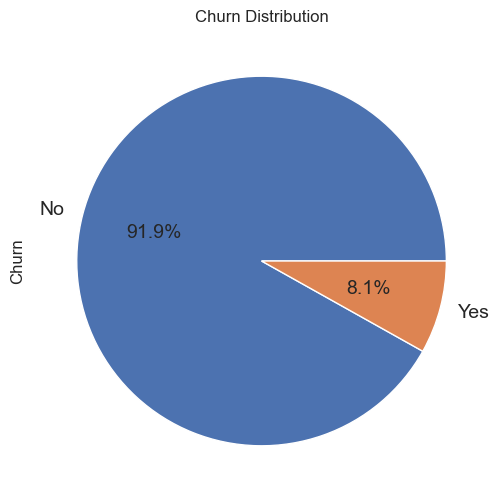

In [134]:
# Churn Distribution
churn_distribution = pca_telecom_churns['churn'].value_counts(normalize=True) * 100

ax = churn_distribution.plot.pie(autopct='%.1f%%', labels=['No', 'Yes'], figsize=(8, 6), fontsize=14)
ax.set_ylabel('Churn', fontsize=12)
ax.set_title('Churn Distribution', fontsize=12)

plt.show()

In [135]:
# normalizing all fields by scaling the data
X_scaled = scale_data(X)
X_scaled.shape

(29953, 79)

In [136]:
X_scaled.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-0.59,-0.51,-0.70,-0.17,-0.19,-0.34,-0.65,-0.30,-0.24,-0.37,-0.38,-0.15,-0.04,-0.32,-0.02,-0.39,-0.66,-0.31,-0.19,-0.27,-0.13,-0.24,-0.16,-0.10,-0.86,-0.54,0.53,1.10,-0.21,1.62,0.66,-0.32,-0.26,-0.38,-0.42,1.28,-0.18,-0.25,-0.33,-0.13,-0.82,-0.60,-0.82,-0.22,-0.25,-0.38,-0.70,-0.30,-0.27,-0.44,-0.47,-0.16,-0.05,-0.37,-0.14,-0.42,-0.73,-0.35,-0.20,-0.32,-0.15,-0.27,-0.15,-0.10,-0.96,-0.69,0.53,1.30,-0.28,1.68,0.64,-0.37,-0.29,-0.46,-0.47,1.36,-0.23,-0.30,-0.19
1,5.30,-0.40,-0.02,0.26,0.17,-0.17,0.04,2.43,-0.24,-0.34,-0.26,1.38,0.18,-0.00,-0.02,-0.22,-0.12,0.58,0.23,1.10,0.99,-0.24,0.29,1.09,-0.32,4.99,8.19,4.73,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.43,-0.26,-0.29,1.51,-0.47,0.29,0.16,-0.06,-0.20,0.92,2.49,-0.27,-0.41,-0.36,1.00,-0.05,-0.24,-0.14,-0.13,0.33,2.50,0.12,0.84,2.26,0.43,-0.04,1.03,-0.79,1.02,6.57,-0.87,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.38,-0.40
2,-0.74,-0.43,-0.41,-0.17,-0.19,-0.29,-0.43,-0.30,0.76,-0.32,-0.20,-0.15,-0.04,0.18,-0.02,-0.39,-0.61,-0.33,-0.19,-0.26,-0.13,-0.24,-0.16,-0.10,0.43,-0.76,-0.75,-0.57,0.46,-0.45,-0.27,-0.34,-0.37,-0.38,0.77,-0.34,-0.18,-0.93,-0.35,-0.16,-0.29,0.27,-0.63,-0.22,-0.25,0.77,-0.38,-0.30,-0.27,-0.12,-0.44,-0.16,-0.05,-0.37,-0.14,-0.31,-0.56,-0.35,-0.20,-0.18,-0.15,-0.27,-0.15,-0.10,0.95,-0.28,-0.32,-0.65,-0.28,-0.02,-0.26,0.17,0.02,0.83,-0.27,-0.39,-0.23,0.88,-0.25
3,0.26,-0.33,1.35,-0.17,-0.19,-0.24,-0.20,-0.22,-0.24,-0.22,1.76,-0.15,-0.04,-0.32,-0.02,-0.27,-0.08,-0.09,-0.19,0.71,-0.13,-0.24,-0.16,-0.10,1.84,0.22,-0.64,-0.29,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.51,-0.40,-0.29,-0.01,-0.33,0.99,-0.22,-0.25,-0.36,-0.32,-0.29,-0.27,-0.15,1.40,-0.16,-0.05,-0.37,-0.14,-0.38,-0.26,-0.27,-0.07,0.24,-0.15,-0.27,-0.15,-0.10,1.41,-0.04,-0.78,-0.65,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.43,-0.40
4,-0.28,-0.44,-0.27,-0.17,-0.19,-0.20,-0.01,-0.30,2.24,-0.37,-0.29,-0.15,-0.04,0.55,-0.02,0.09,0.00,-0.32,-0.01,0.15,-0.13,-0.24,-0.10,0.93,-0.64,-0.24,0.11,-0.64,0.13,0.96,0.76,-0.34,0.72,-0.38,-0.42,1.28,0.72,-0.63,-0.31,0.05,-0.99,-0.49,-0.63,-0.22,-0.25,-0.16,-0.35,-0.30,-0.27,-0.44,-0.46,-0.16,-0.05,-0.37,-0.14,-0.16,-0.22,-0.35,-0.20,-0.23,-0.15,-0.27,0.04,0.10,-0.90,-0.84,-0.53,-0.10,-0.28,0.10,0.23,-0.42,-0.07,-0.46,-0.47,1.36,-0.23,-0.36,-0.11


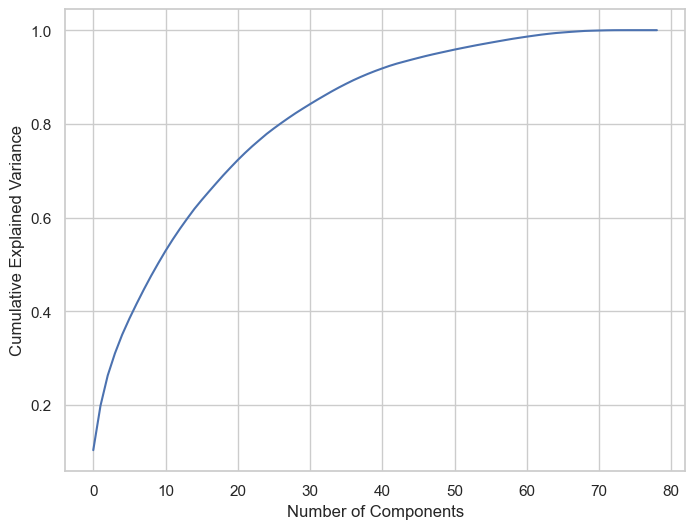

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [137]:
# Scree plot
pca = get_scree_plot(X_scaled)

# Creating a DataFrame with top principal components and corresponding features
pca_df = pd.DataFrame(pca.components_[:3].T, columns=['PC1', 'PC2', 'PC3'])
pca_df['Feature'] = X_scaled.columns
pca_df.head(10)

In [138]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

array([ 10.34,  19.83,  26.28,  31.01,  34.99,  38.42,  41.6 ,  44.64,
        47.53,  50.26,  52.88,  55.32,  57.61,  59.77,  61.85,  63.73,
        65.53,  67.3 ,  69.04,  70.69,  72.3 ,  73.81,  75.24,  76.57,
        77.88,  79.06,  80.18,  81.26,  82.3 ,  83.28,  84.23,  85.16,
        86.06,  86.95,  87.79,  88.58,  89.34,  90.04,  90.69,  91.3 ,
        91.86,  92.4 ,  92.88,  93.3 ,  93.71,  94.11,  94.5 ,  94.86,
        95.2 ,  95.54,  95.87,  96.18,  96.49,  96.79,  97.07,  97.35,
        97.63,  97.9 ,  98.16,  98.4 ,  98.63,  98.84,  99.05,  99.23,
        99.39,  99.52,  99.64,  99.75,  99.85,  99.9 ,  99.94,  99.98,
       100.  , 100.01, 100.01, 100.01, 100.01, 100.01, 100.01])

It appears that 60 components are sufficient to capture 95% of the variance in the dataset. Consequently, will opt for 60 components for modeling.

In [139]:
x_train, x_test, y_train, y_test = resampling_data(X_scaled,Y,60)

Original Train Dataset Shape        : (20967, 79)
Percentage of Churned Customer Data : 8.12%
Train Dataset Shape after SMOTE     : (38528, 79)
Train Dataset Shape after PCA       : (38528, 60)


In [140]:
x_train.shape

(38528, 60)

SMOTE augmented the dataset by introducing synthetic data points to balance it, effectively addressing the class imbalance by incorporating artificially generated values.

##### Logistic Regression Modelling

In [141]:
#Training the model on the train data
lr = LogisticRegression()
lr_model = lr.fit(x_train, y_train)

# Making predictions on the test data
pred_probs_test = lr_model.predict_proba(x_test)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, pred_probs_test)

print(f"Linear Regression Accuracy: {roc_auc:.2f}")

Linear Regression Accuracy: 0.89


##### SVM Regression Modelling

Initially construct two fundamental models - linear and non-linear, utilizing default hyperparameters, and then compare their accuracies.

In [142]:
# Preparing data
svm_telecom_churns = final_telecom_churns.copy()
x_train, x_test, y_train, y_test = get_regression_data(svm_telecom_churns)

Original Train Dataset Shape        : (20967, 79)
Percentage of Churned Customer Data : 8.12%
Train Dataset Shape after SMOTE     : (38528, 79)
Train Dataset Shape after PCA       : (38528, 60)


Model selected - LINEAR and accuracy score for kernel is 83.0
SVM (Default)-linear Model Stats Scores Summary: 


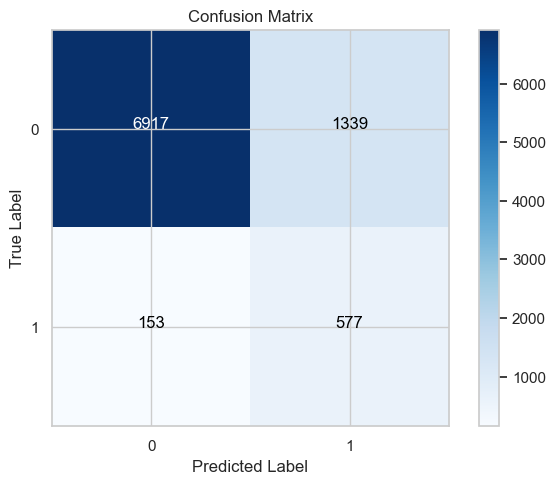

In [143]:
# apply Regression
model_matrics_svm_linear = get_svm_model_stats(x_train, x_test, y_train, y_test,"linear")

In [144]:
model_matrics_svm_linear

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM (Default)-linear,0.83,0.79,0.30,0.81,0.44


Model selected - RBF and accuracy score for kernel is 87.0
SVM (Default)-rbf Model Stats Scores Summary: 


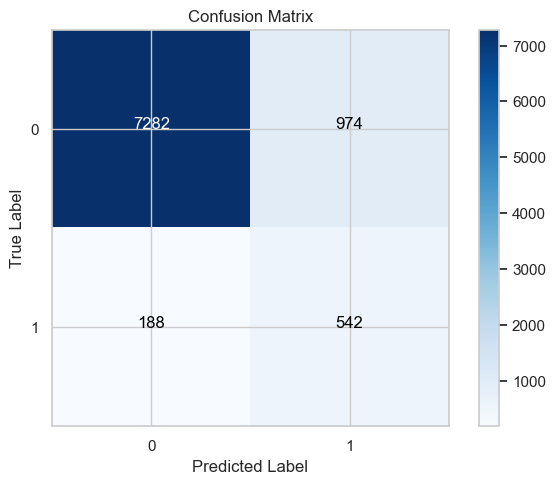

In [145]:
model_matrics_svm_rbf = get_svm_model_stats(x_train,x_test, y_train, y_test,"rbf")

In [146]:
model_matrics_svm_rbf

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM (Default)-rbf,0.87,0.74,0.36,0.81,0.48


The non-linear model achieves approximately 87% accuracy. Consequently, for further analysis, proceed with the hyperparameters associated with ~non-linear models.

**Grid Search: Hyperparameter Tuning**

Now, fine-tune the model to determine the optimal values of C and gamma for the RBF kernel, utilizing 5-fold cross-validation.

In [147]:
# Creating a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=101)

# Define hyperparameters for grid search
hyper_params = {'gamma': [1e-1, 1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}

# Specify the SVM model with an RBF kernel
svm_model = svm.SVC(kernel="rbf")

# Set up GridSearchCV
model_cv_svm = GridSearchCV(estimator=svm_model,
                            param_grid=hyper_params,
                            scoring='accuracy',
                            cv=folds,
                            n_jobs=-1,
                            verbose=1,
                            return_train_score=True)

# Fit the model
model_cv_svm.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001]},
             return_train_score=True, scoring='accuracy', verbose=1)

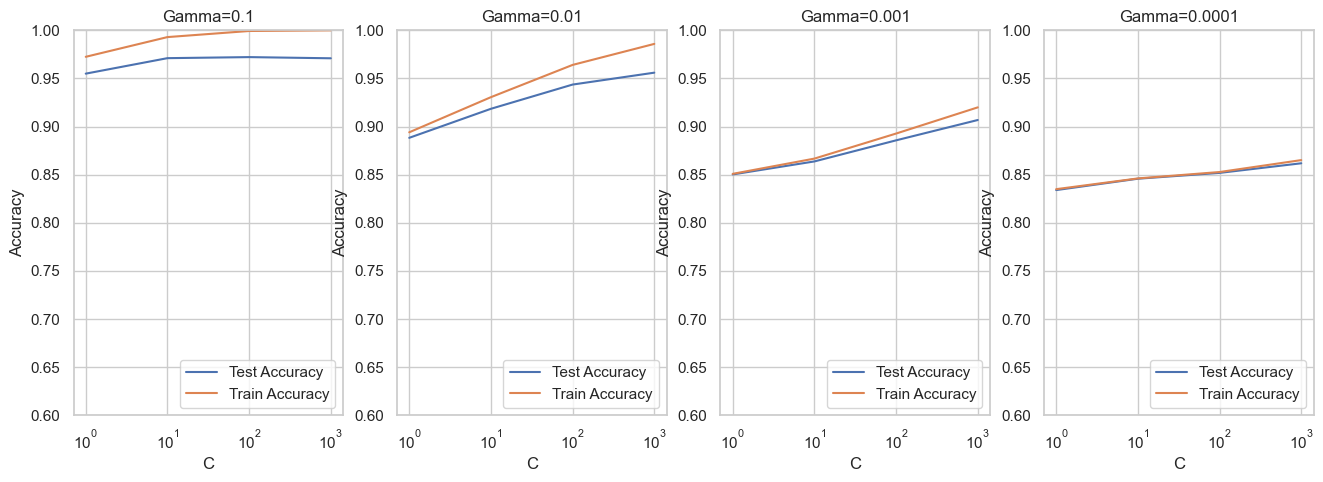

In [148]:
# cv results
svm_cv_results = pd.DataFrame(model_cv_svm.cv_results_)
svm_cv_results['param_C'] = svm_cv_results['param_C'].astype('int')

gamma_values = [1e-1, 1e-2, 1e-3, 1e-4]

plt.figure(figsize=(16, 5))

for i, gamma_val in enumerate(gamma_values, 1):
    plt.subplot(140 + i)
    display_hyper_stats(svm_cv_results, gamma_val)

plt.show()

The presented plots provide valuable insights:

 1. Non-linear models (high gamma) exhibit superior performance compared to linear ones.
 2. Higher values of C contribute to improved model performance across different gamma values.
 3. The model with gamma = 0.1 appears to overfit, while the other values demonstrate favorable performance.
 4. These observations suggest that the nature of the problem and data is inherently non-linear, implying that a more complex model will outperform simpler, linear models in this scenario.

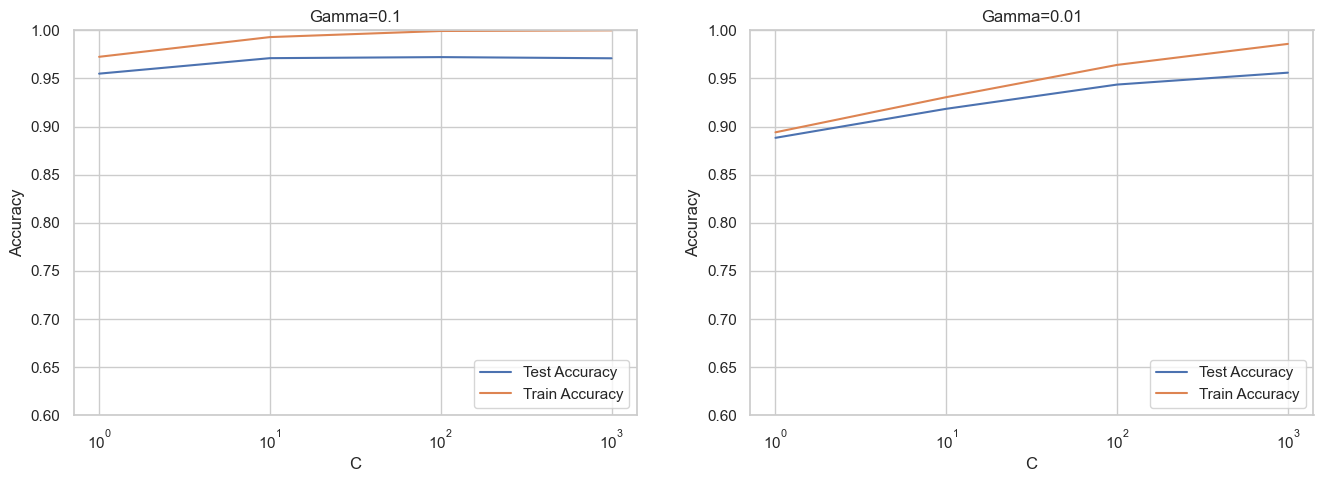

In [149]:
plt.figure(figsize=(16, 5))

for i in range(2):
    plt.subplot(121 + i)
    display_hyper_stats(svm_cv_results, gamma_values[i])

plt.show()

In [150]:
# printing the optimal accuracy score and hyperparameters
best_score, best_hyperparams = round(model_cv_svm.best_score_, 2), model_cv_svm.best_params_
print(f"The optimal test score is {best_score}, achieved with hyperparameters {best_hyperparams}")

The optimal test score is 0.97, achieved with hyperparameters {'C': 100, 'gamma': 0.1}


The insights from the plots and analysis suggest the following:

 1. The model with gamma=0.1 appears to be overfitting and is not recommended for use.
 2. Although the best-performing model has hyperparameters 'C': 100, 'gamma': 0.1, it also shows signs of overfitting.
 3. A more balanced choice is the model with 'C': 10, 'gamma': 0.1, which is expected to produce better results.

Therefore, the model with 'C': 10, 'gamma': 0.1 will be selected for the final modeling.

**Building and Evaluating the Final Model**

In [151]:
# Create the final SVM model with optimal hyperparameters
final_svm_model = svm.SVC(C=10, gamma=0.1, kernel="rbf")

# Train the model on the training data
final_svm_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = final_svm_model.predict(x_test)

# Print the accuracy score
accuracy = round(metrics.accuracy_score(y_test, y_pred), 2)
print(f"Max accuracy with SVM (rbf) is {accuracy}")

Max accuracy with SVM (rbf) is 0.92


SVM(rfb) [Hyper] Model Stats Scores Summary: 


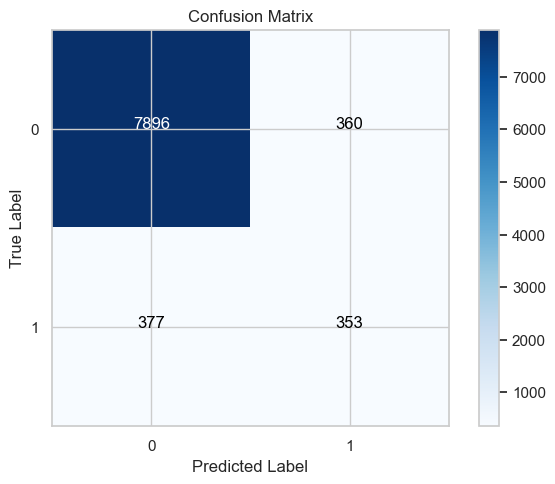

In [152]:
model_metrics_svm = get_model_metrics(y_test, y_pred,"SVM(rfb) [Hyper]")

In [153]:
model_metrics_svm

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM(rfb) [Hyper],0.92,0.48,0.50,0.72,0.49


##### Tree Model Regression

*Begin by training a Random Forest model using default hyperparameters to establish a baseline performance for comparison.*

In [154]:
tree_telecom_churns = final_telecom_churns.copy()
x_train, x_test, y_train, y_test = get_regression_data(tree_telecom_churns)

Original Train Dataset Shape        : (20967, 79)
Percentage of Churned Customer Data : 8.12%
Train Dataset Shape after SMOTE     : (38528, 79)
Train Dataset Shape after PCA       : (38528, 60)


In [155]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [156]:
# make predictions
predictions = rfc.predict(x_test)

RandomForest (Default) Model Stats Scores Summary: 


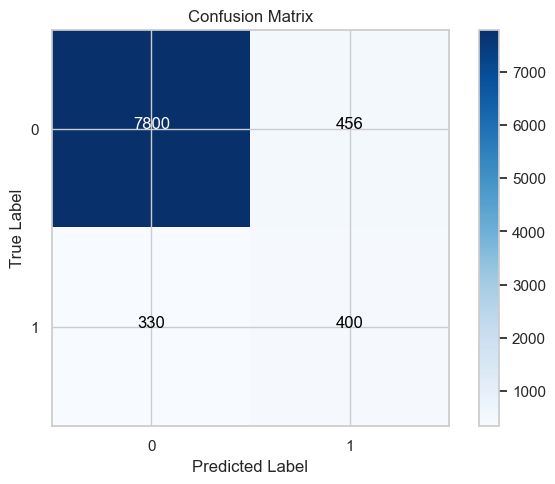

In [157]:
model_metrics_rfc = get_model_metrics(y_test,predictions,"RandomForest (Default)")

In [158]:
model_metrics_rfc

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.91,0.55,0.47,0.75,0.50


According to above, it is good to explore the hyperparameters available for tuning in order to enhance the model performance.

##### Hyperparameter Tuning

In [159]:
def tune_hyperparameter(parameters, x_train, y_train, n_folds=5, max_depth=0):
    """
    Tune hyperparameters for a RandomForestClassifier using GridSearchCV and plot the results.

    Parameters:
    - parameters: dict, hyperparameter grid for RandomForestClassifier
    - x_train: DataFrame, training data features
    - y_train: Series, training data labels
    - n_folds: int, number of folds for cross-validation
    - max_depth: int, maximum depth for RandomForestClassifier (default: 0, indicating no limit)
    """
    if max_depth == 0:
        rf = RandomForestClassifier()
    else:
        rf = RandomForestClassifier(max_depth=max_depth)

    rf = GridSearchCV(rf, parameters, cv=n_folds, n_jobs=-1, scoring="accuracy", return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    hyperparameters = list(parameters.keys())[0]

    # plotting accuracies for parameters
    plt.figure(figsize=(16, 5))
    plt.plot(scores["param_" + hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_" + hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

**Tuning max_depth**

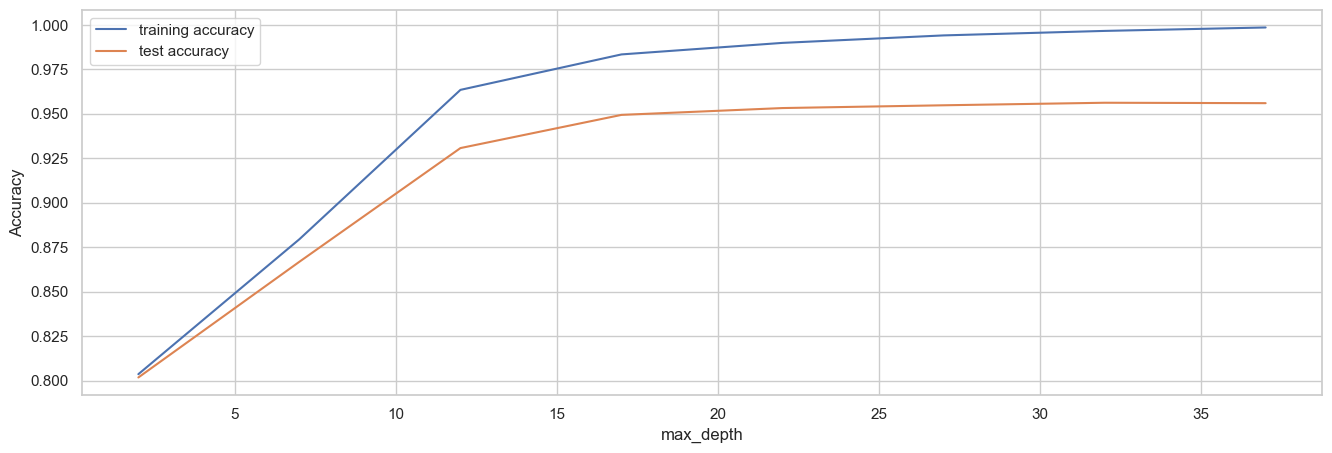

In [160]:
# establish the set of parameters that will be used to build the model
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

According to above, increasing the value of max_depth leads to an improvement in both train and test scores up to a certain point. However, beyond that point, the test score plateaus, indicating that the ensemble tends to overfit with higher max_depth values. To prevent overfitting, it's beneficial to control the depth of the individual trees in the forest. Values such as 12 and 18 show optimal convergence and can be considered for grid view search.

**Tuning n_estimators**

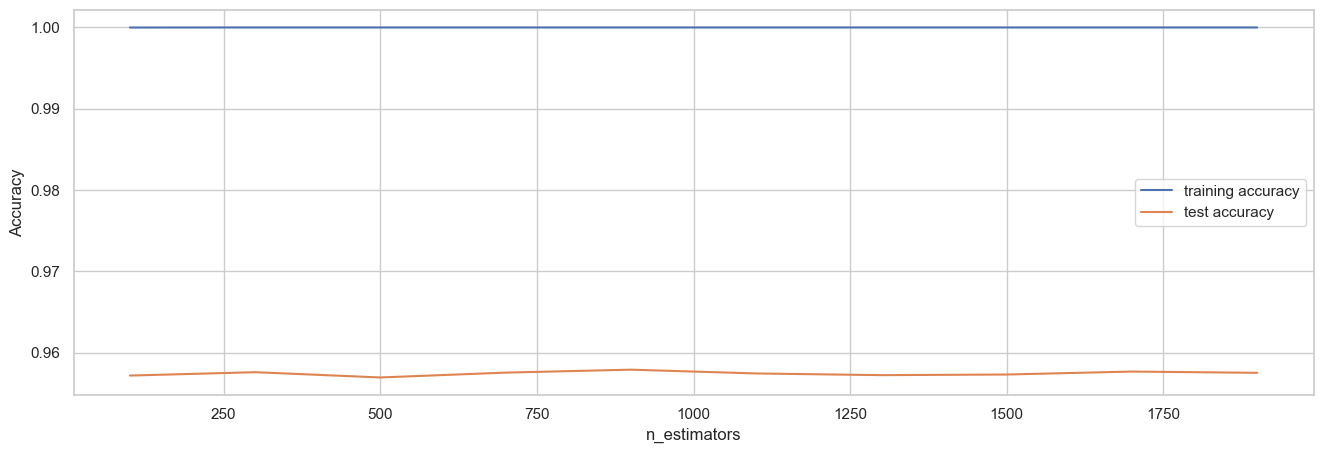

In [161]:
# establish the set of parameters that will be used to build the model
parameters = {'n_estimators': range(100, 2000, 200)}
tune_hyperparameter(parameters,x_train,y_train)

The scores exhibit minimal variation with a slight dip across the entire range. Hence, we'll opt for a value of 200 for the grid view search.

**Tuning max_features**

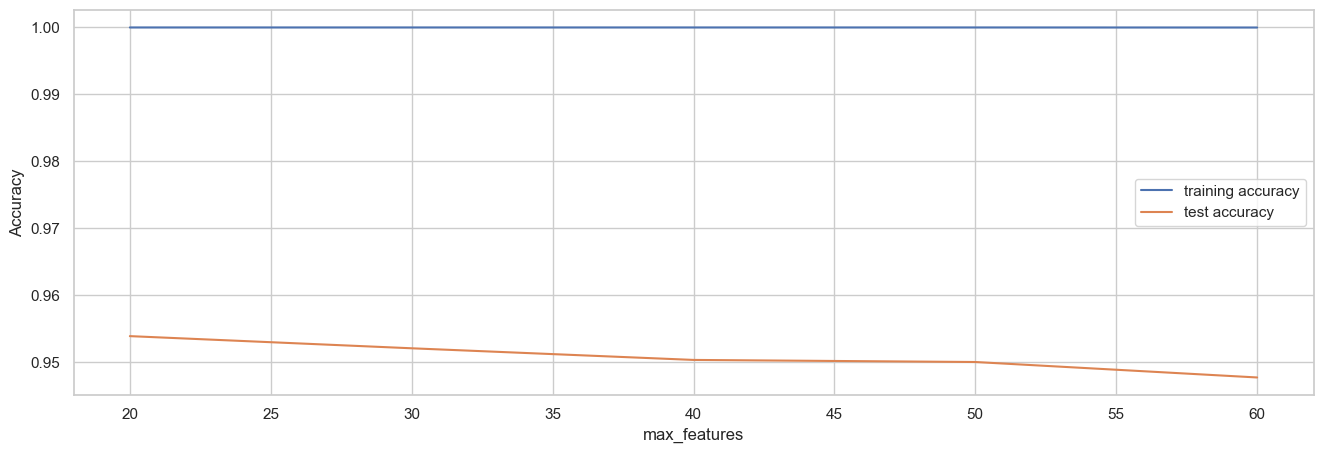

In [162]:
# establish the set of parameters that will be used to build the model
parameters = {'max_features': [20,30,40,50,60]}
tune_hyperparameter(parameters,x_train,y_train,4)

The training accuracy appears stable, while the test scores show an increase until 30, followed by a decrease. There is another increase around 40, and we will consider this value for further analysis.

**Tuning min_samples_leaf**

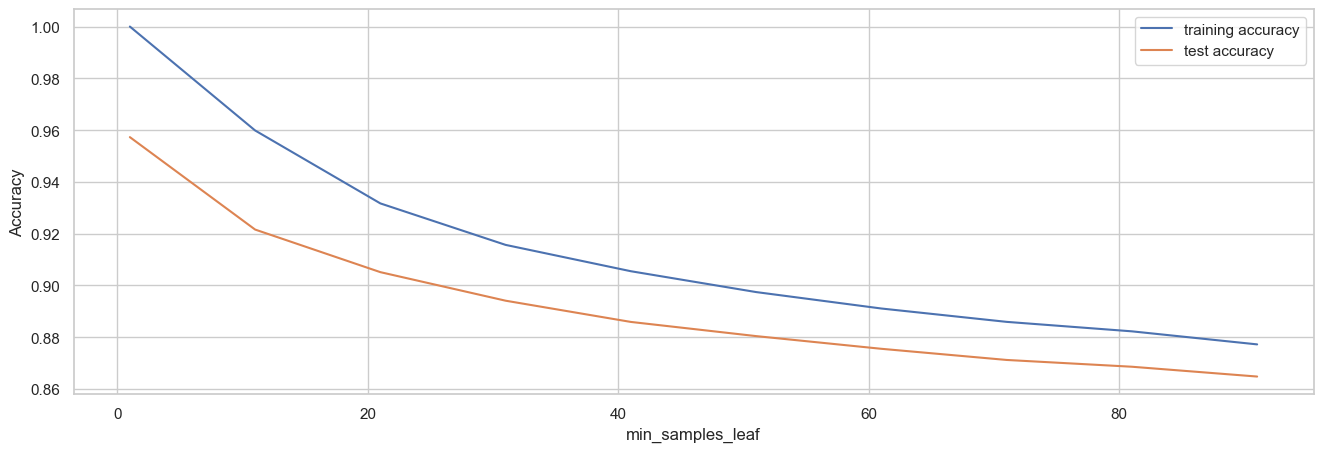

In [163]:
# establish the set of parameters that will be used to build the model
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

The model begins to overfit as the value of min_samples_leaf decreases. A range of 10 to 20 appears to be suitable, and these values will be considered in the grid search.

**Tuning min_samples_split**

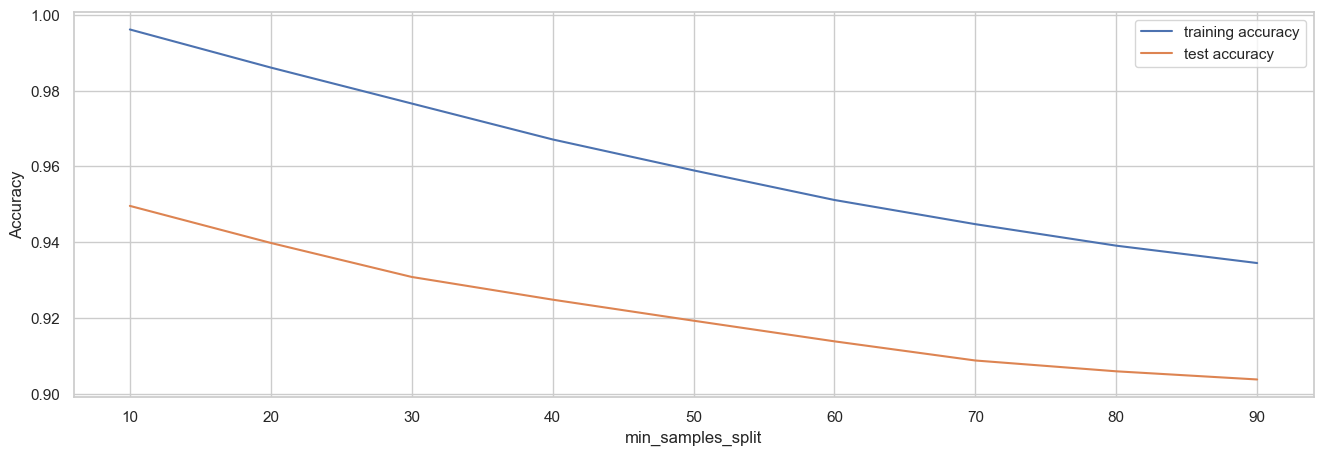

In [164]:
# establish the set of parameters that will be used to build the model
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

A range of 10 to 30 appears to be optimal, yielding good accuracy for the model.

**Performing a grid search to find the optimal hyperparameters for the model**

In [165]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [12, 18],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [10, 20, 30]
}

# Create a base random forest model
rf = RandomForestClassifier()

# Initialize the grid search model
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                            cv=5, n_jobs=-1, verbose=1, return_train_score=True)


In [166]:
# Fit the grid search model to the data
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [12, 18], 'max_features': [40],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [193]:
# printing the optimal accuracy score and hyperparameters
print(f"The optimal hyperparameters for the random forest model are \n{str(rf_grid_search.best_params_)}, \nachieving an accuracy of {str(round(rf_grid_search.best_score_,2))}.")

The optimal hyperparameters for the random forest model are 
{'max_depth': 18, 'max_features': 40, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}, 
achieving an accuracy of 0.93.


In [168]:
print(f"The maximum accuracy achieved with the Random Forest classifier is {str(round(rf_grid_search.best_score_,2))}.")

The maximum accuracy achieved with the Random Forest classifier is 0.93.


**Building and Evaluating the Final Model for Random Forest**

In [169]:
# Create and fit the Random Forest classifier with optimal hyperparameters
rfc = RandomForestClassifier(max_depth=18,
                            max_features=40,
                            min_samples_leaf=10,
                            min_samples_split=20,
                            n_estimators=200,
                            n_jobs=-1)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=18, max_features=40, min_samples_leaf=10,
                       min_samples_split=20, n_estimators=200, n_jobs=-1)

In [170]:
# make predictions
predictions = rfc.predict(x_test)

RandomForest (Hyper) Model Stats Scores Summary: 


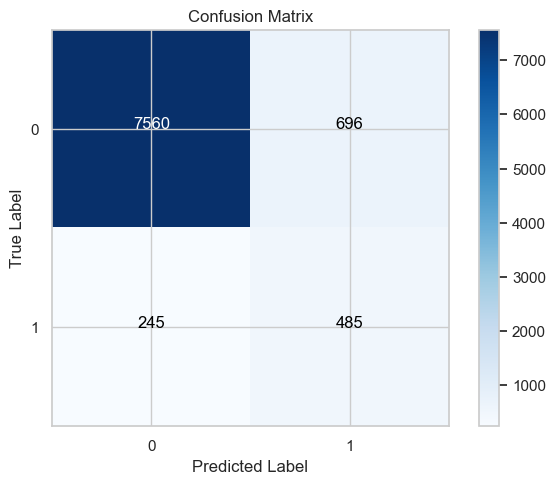

In [171]:
# print confusion matrix
model_metrics_rfc_hyper = get_model_metrics(y_test,predictions,'RandomForest (Hyper)')

In [172]:
model_metrics_rfc_hyper

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Hyper),0.90,0.66,0.41,0.79,0.51


##### XGBoost

In [173]:
def plot_for_xgboost(param_grid, cv_results):
    """
    Plot the performance of XGBoost models with different hyperparameters.

    Parameters:
    - param_grid: dict, hyperparameter grid for XGBoost
    - cv_results: DataFrame, cross-validation results
    """
    plt.figure(figsize=(18, 5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1, len(param_grid['subsample']), n + 1)
        df = cv_results[cv_results['param_subsample'] == subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='best')
        plt.xscale('log')

In [174]:
xgboost_telecom_churns = final_telecom_churns.copy()
x_train, x_test, y_train, y_test = get_regression_data(xgboost_telecom_churns)

Original Train Dataset Shape        : (20967, 79)
Percentage of Churned Customer Data : 8.12%
Train Dataset Shape after SMOTE     : (38528, 79)
Train Dataset Shape after PCA       : (38528, 60)


In [175]:
# fit model on training data with default hyperparameters
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [176]:
# make predictions
y_pred = xgb_model.predict(x_test)

XGBoost (Default) Model Stats Scores Summary: 


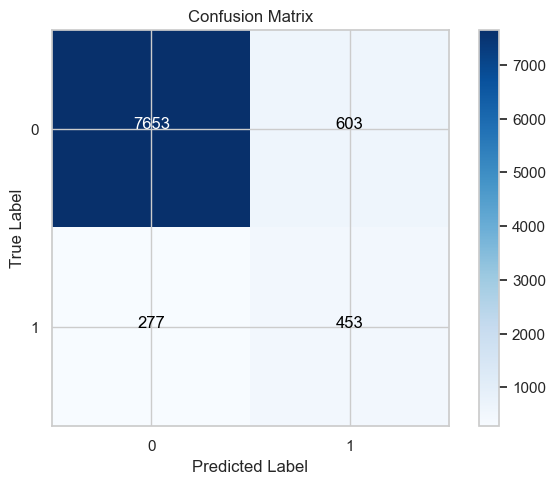

In [177]:
model_metrics_xgb = get_model_metrics(y_test, y_pred ,'XGBoost (Default)')

In [178]:
model_metrics_xgb

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default),0.90,0.62,0.43,0.77,0.51


In [179]:
print(f"The AUC-ROC score with default hyperparameters is approximately {model_metrics_xgb['AUC'].iloc[0]:.2f}%.")

The AUC-ROC score with default hyperparameters is approximately 0.77%.


**Tuning the hyperparameters using k-fold CV and then use grid search CV to find the optimal values of hyperparameters**

In [180]:
# Hyperparameter tuning with XGBoost
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.3, 0.4, 0.5]
}

xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

model_cv_xgb = GridSearchCV(estimator=xgb_model, 
                        param_grid=param_grid, 
                        scoring='accuracy', 
                        cv=5, 
                        n_jobs=-1, 
                        verbose=1, 
                        return_train_score=True)

In [181]:
# fit the model
model_cv_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [182]:
# CV results for XGBoost
xgboost_cv_results = pd.DataFrame(model_cv_xgb.cv_results_)
xgboost_cv_results['param_learning_rate'] = xgboost_cv_results['param_learning_rate'].astype(float)

In [183]:
# print the optimal accuracy score and hyperparameters
print(f"An accuracy of {round(model_cv_xgb.best_score_, 2)} with the hyperparameters: {model_cv_xgb.best_params_}")

An accuracy of 0.88 with the hyperparameters: {'learning_rate': 0.3, 'subsample': 0.5}


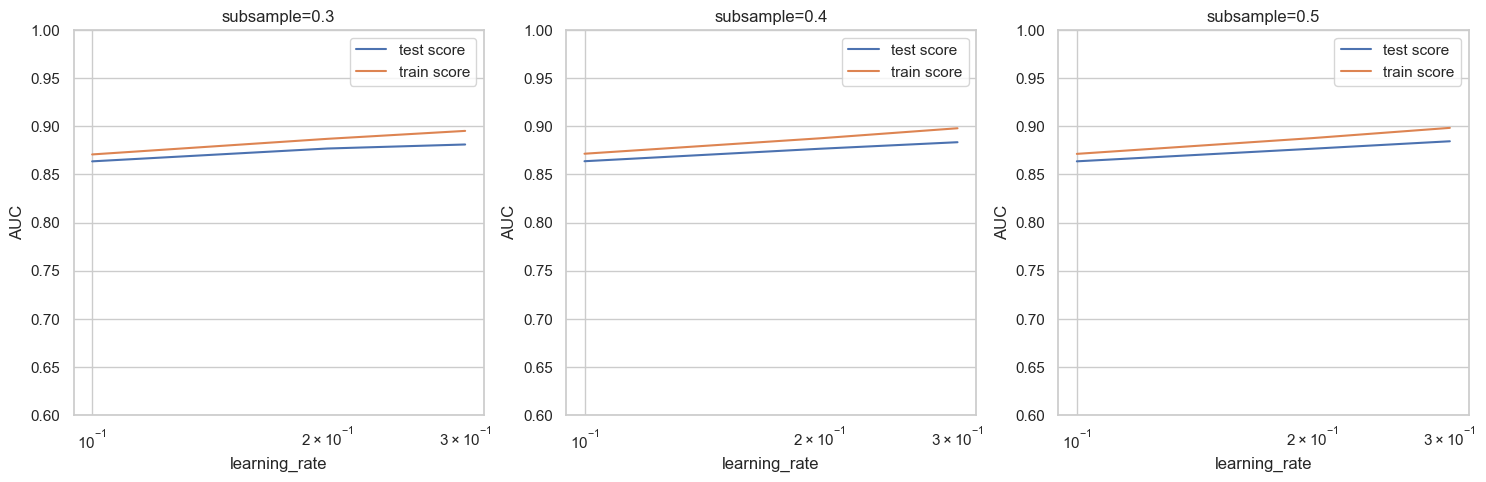

In [184]:
param_grid1 = {'learning_rate': [0.1, 0.2, 0.3], 'subsample': [0.3, 0.4, 0.5]}  
plot_for_xgboost(param_grid1, xgboost_cv_results)

The outcomes indicate that a subsample size of 0.5 and a learning rate of approximately 0.3 appear to be optimal. Additionally, XGBoost has yielded the highest ROC AUC across various hyperparameters.

In [185]:
# Chosen hyperparameters
xgb_params = {'learning_rate': 0.3,
            'max_depth': 2, 
            'n_estimators': 200,
            'subsample': 0.5,
            'objective': 'binary:logistic'}

# Build the final model with selected hyperparameters
final_xgb_model = XGBClassifier(**xgb_params)
final_xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [186]:
# predict
y_pred = final_xgb_model.predict(x_test)

XGBoost (Hyper Tuned) Model Stats Scores Summary: 


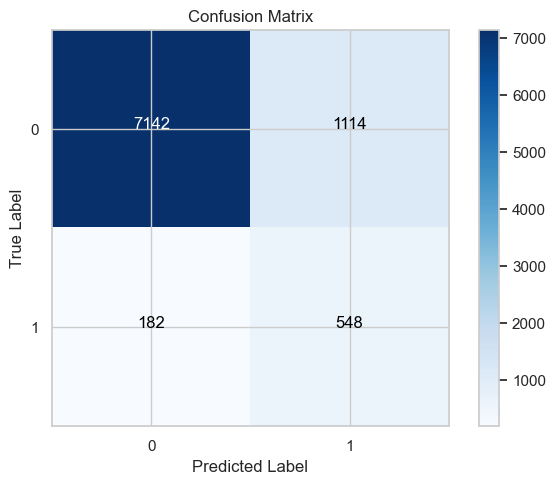

In [187]:
model_metrics_xgb_tuned = get_model_metrics(y_test, y_pred,'XGBoost (Hyper Tuned)')

In [188]:
model_metrics_xgb_tuned

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.86,0.75,0.33,0.81,0.46


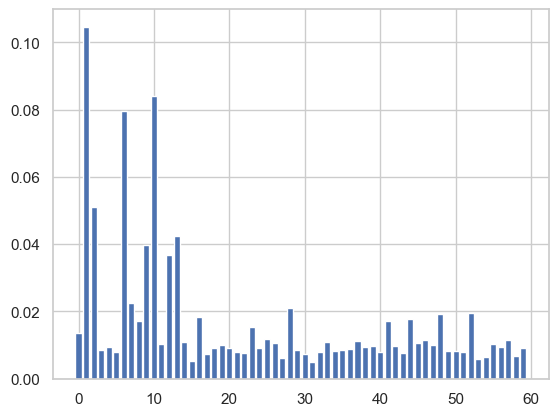

In [189]:
# plot
plt.bar(range(len(final_xgb_model.feature_importances_)), final_xgb_model.feature_importances_)
plt.show()

Important features


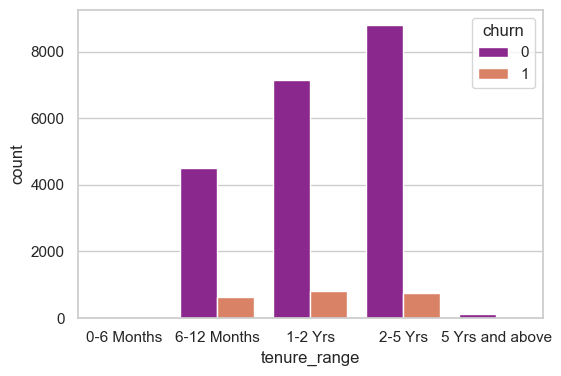

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [190]:
# Visualizing important features
print("Important features")
plt.figure(figsize=(6, 4))
sns.countplot(x='tenure_range', hue='churn', data=tenures, palette='plasma')
plt.show()

# Principal Component Analysis (PCA) results
col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1': pca.components_[0], 'PC2': pca.components_[1], 'PC3': pca.components_[2], 'Feature': col})
df_pca.head(15)

### Recommendations

##### Business Insights

 1. Less number of high-value customers are churning, but there has been no addition of new high-value customers in the last 6 months, which is a concerning trend. The company should focus on acquiring new high-value customers.

 2. The analysis reveals that local outgoing calls made to landline, fixed line, mobile, and call center are strong indicators of potential churn behavior. The company should focus on improving the quality or attractiveness of these calling services to reduce churn rates.

 3. The average revenue per user (ARPU) appears to be the most significant feature in predicting customer churn. To mitigate churn, the company should explore strategies to enhance the value and satisfaction of high ARPU customers.

 4. Customers with less than 4 years of tenure are more likely to churn. The company should focus on implementing new schemes or offers specifically targeted at this segment to improve customer retention.
 
 5. The analysis suggests that customers experiencing poor 2G/3G coverage in certain areas are more likely to churn. To address this, the company should prioritize enhancing 2G/3G network coverage in those specific areas to improve customer satisfaction and retention.

 6. The analysis suggests that high volumes of incoming and outgoing calls while roaming in the 8th month are strong indicators of potential churn behavior. The company may need to investigate and address issues related to roaming services to retain customers.

##### Model Insights

In [191]:
model_summary

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM (Default)-linear,0.83,0.79,0.30,0.81,0.44
1,SVM (Default)-rbf,0.87,0.74,0.36,0.81,0.48
2,SVM(rfb) [Hyper],0.92,0.48,0.50,0.72,0.49
3,RandomForest (Default),0.91,0.55,0.47,0.75,0.50
4,RandomForest (Hyper),0.90,0.66,0.41,0.79,0.51
5,XGBoost (Default),0.90,0.62,0.43,0.77,0.51
6,XGBoost (Hyper Tuned),0.86,0.75,0.33,0.81,0.46


1. The Support Vector Machine (SVM) model, fine-tuned with optimized hyperparameters, demonstrated the best performance on this dataset, achieving an accuracy of 92%. This indicates that SVM is a robust choice for predicting customer churn based on the given features.

2. The Random Forest model showcased strong predictive capabilities with a default accuracy of 91%, even in an overfit configuration. After tuning hyperparameters, the model maintained a commendable accuracy of 90%, reinforcing its effectiveness in predicting customer churn in this scenario.

3. XGBoost demonstrated robust performance with a default accuracy of 90%, even in a potentially overfit configuration. Following hyperparameter tuning, the model maintained a reliable accuracy of 86%, emphasizing its suitability for predicting customer churn in this context.

Based on three analysis, both Support Vector Machine (SVM) and Random Forest models have demonstrated the highest accuracy. These models can be considered suitable choices for predicting churn in future datasets or production environments.